## Nonlinear Supervised Learning Series

# Part 6: Gradient Boosting

Gradient boosting is one of the most popular ways of fitting trees to a dataset, and more generally is one of the most popular nonlinear supervised learning methods.  The way in which trees are generated - tuned to a specific dataset - they naturally split up data between consecutive points and along individual input dimensions.  This makes them an ideal sort of nonlinearity for census, metadata, and other forms of high dimensional sparse data like bag of words feature vectors.  The boosting method of combining trees is a greedy one, where a subset of the best trees is determined that best (in linear combination) models the data. 

In this post we discuss the algorithm for gradient boosting regression and classification.  A greedy form of *coordinate descent* lies at the heart of gradient boosting for the iterative selection of tree units, which are quite commonly just decision stumps (first discussed at a high level in the second post in this series).

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
%matplotlib notebook

# thisis needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

# 1.   Generating regression stumps

One of the simplest yet most common type of tree unit is the simple *decision stump* also known as a *depth-1 tree*.  Each stump unit is a piece-wise constant function consisting of two distinct levels, on which the function is constant, separated by a *split point*.  Mathematically we can express a generic stump as follows.

\begin{equation}
f(x) = \begin{cases} L_1 \,\,\,\,\,\text{if} \,\,\,\, x \leq s_1 \\ L_2 \,\,\,\,\, \text{if} \,\,\,\, x > s_1.   \end{cases}  ~~~~~~~~
\end{equation}

Here the split point is written as $s_1$, while the two levels of the stump are written as $L_1$ and $L_2$ respectively.  In their usage for nonlinear regression and classification these parameters of the stump are set with respect to a dataset.  When performing regression or classification with stumps often one generates a complete collection, each of which has its parameters fine-tuned to the particular dataset under study.  

Let us say we have a dataset of $P$ points $\left \{x_p,y_p \right \}_{p=1}^{P}$ where the input has just a single dimension.  A naive (yet common) way of generating stumps for this dataset goes as follows: we create a stump with split point midway between each successive pairs of inputs, and then set the corresponding levels to the average of the outputs to the left and right of the split point respectively.  

We animate this process of stump generation with an example dataset in the next Python cell.  As you move the slider from left to right each increment the next stump is drawn.  For a dataset of $P$ points with single dimensional input like this we create a total of $P-1$ stumps this way.


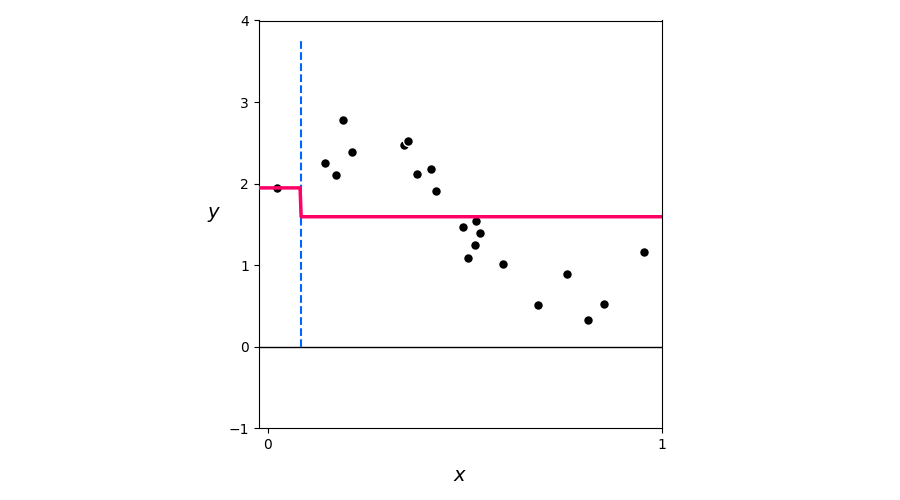
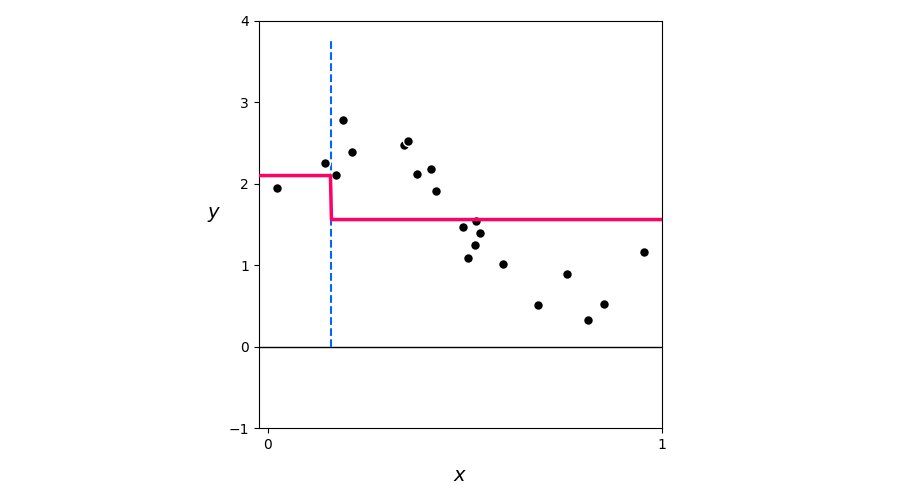
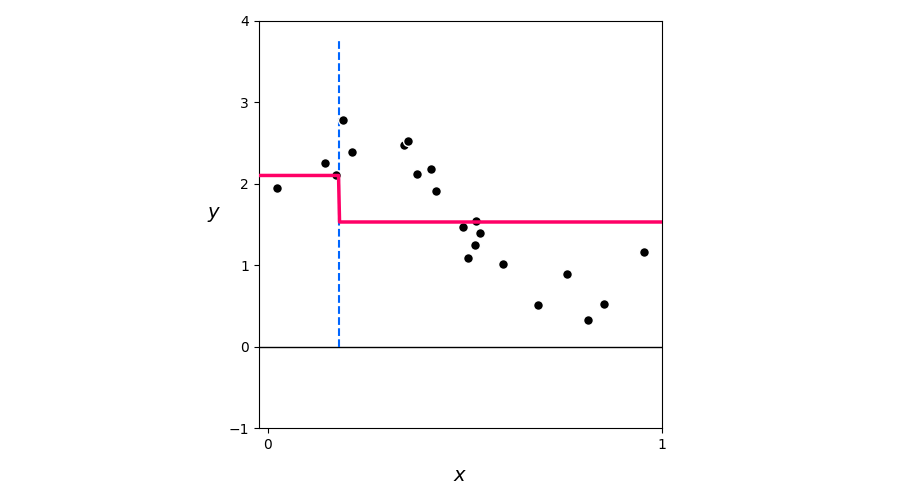
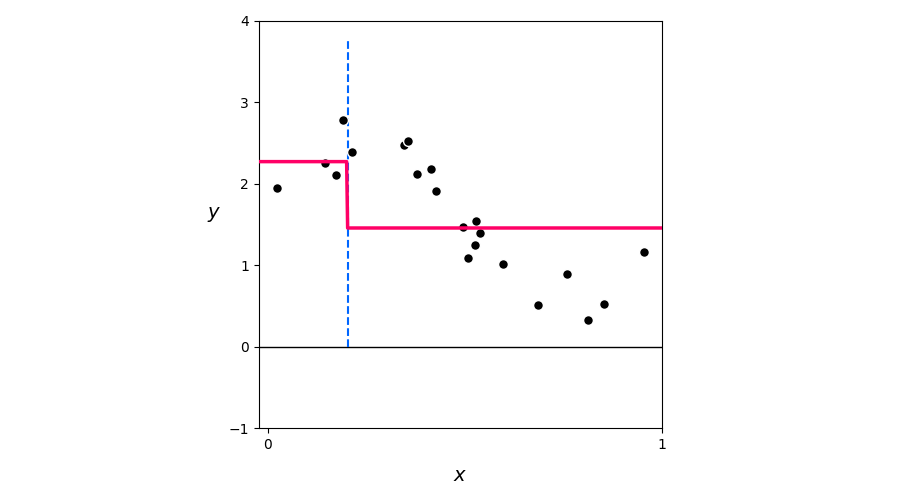
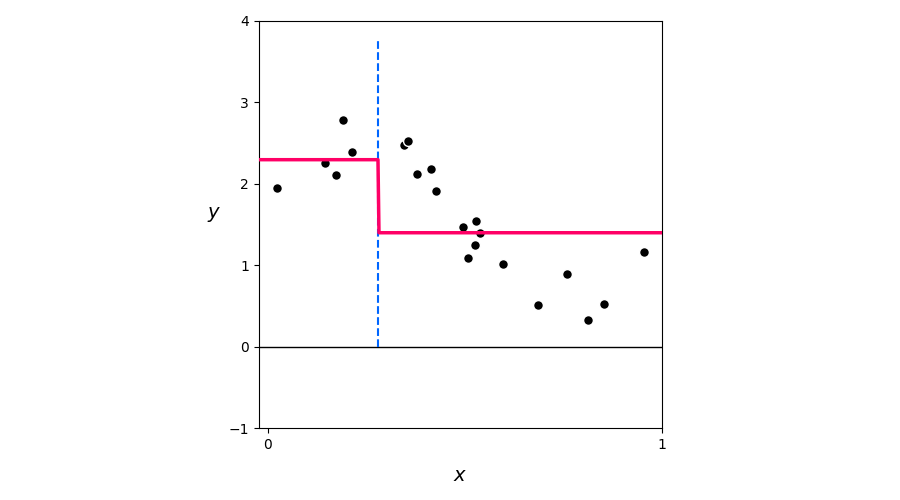
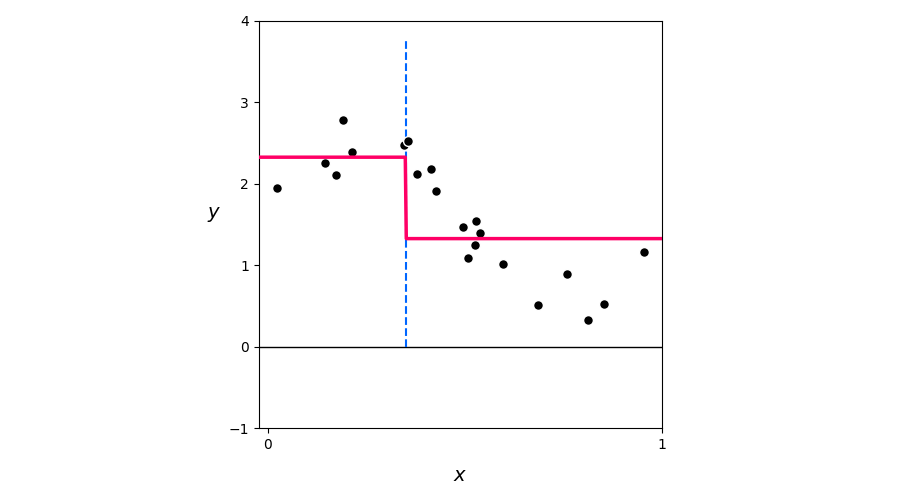
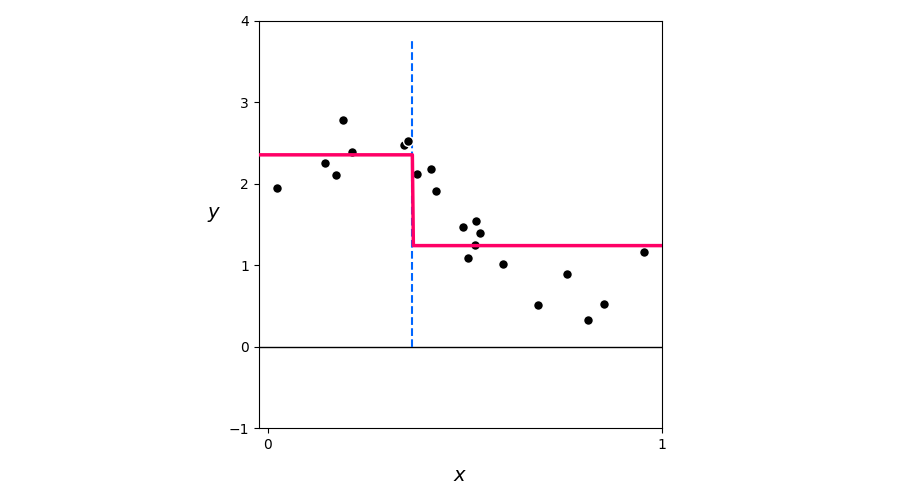
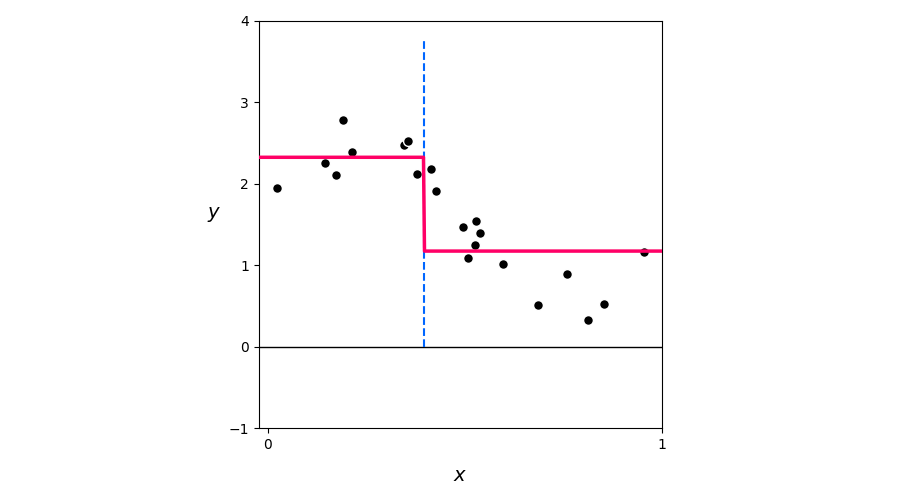
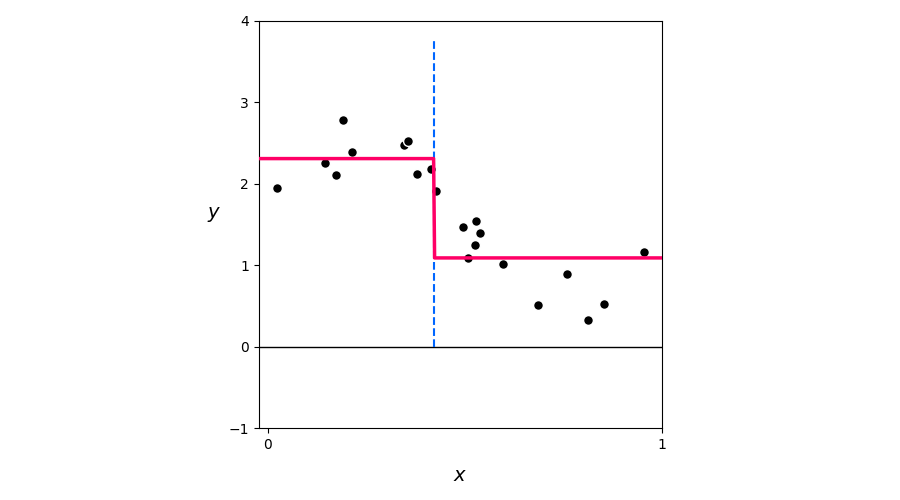
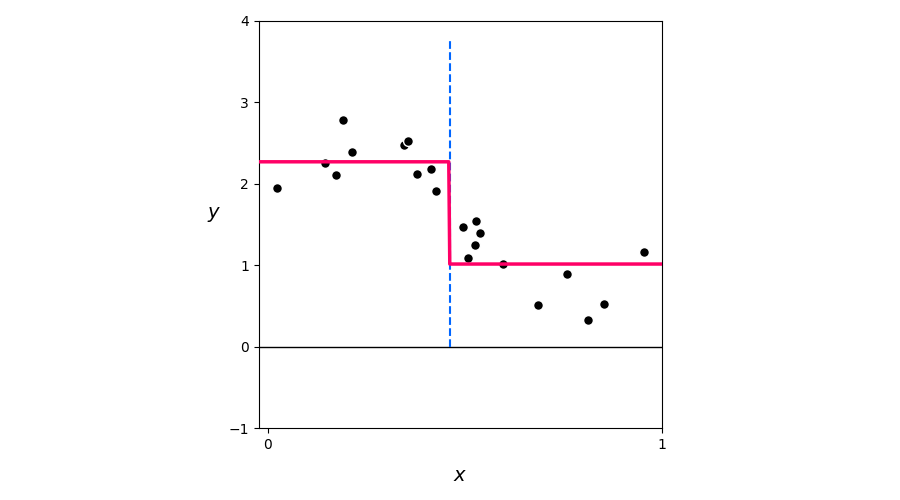
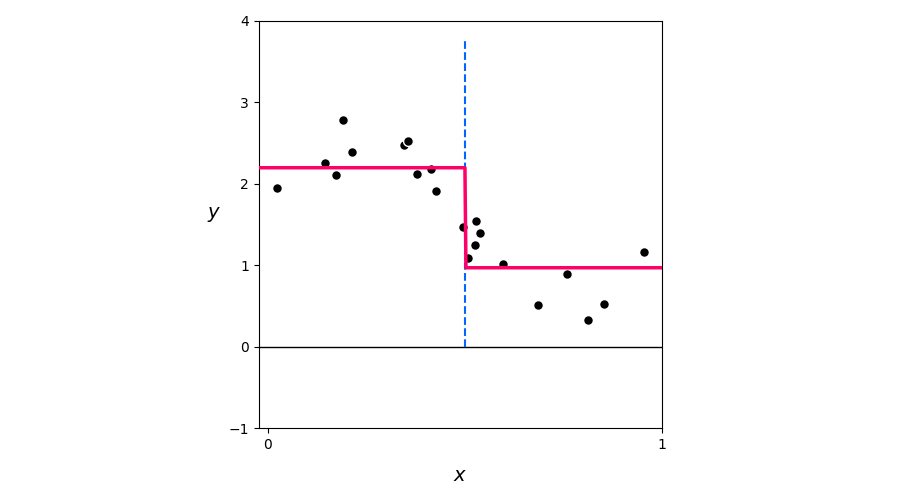
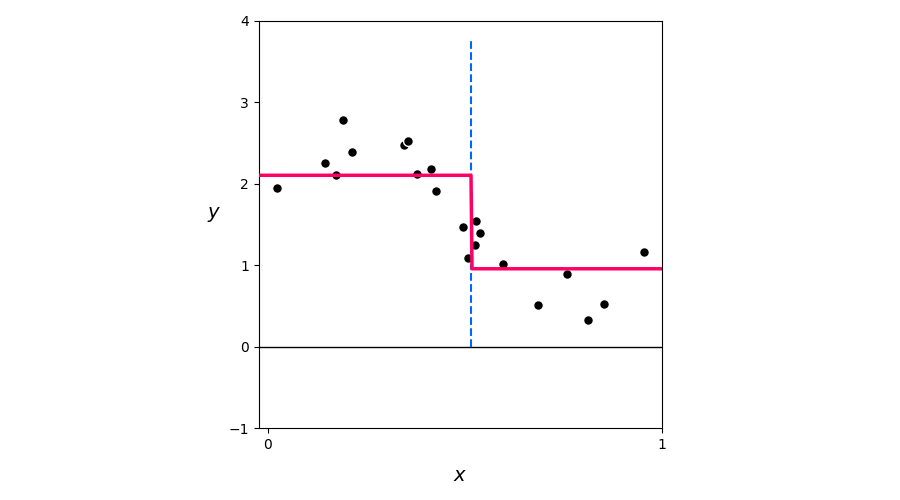
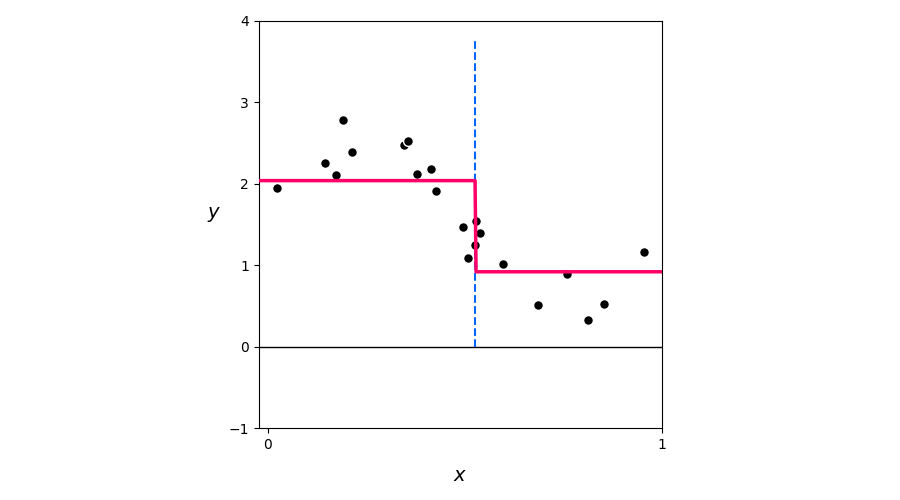
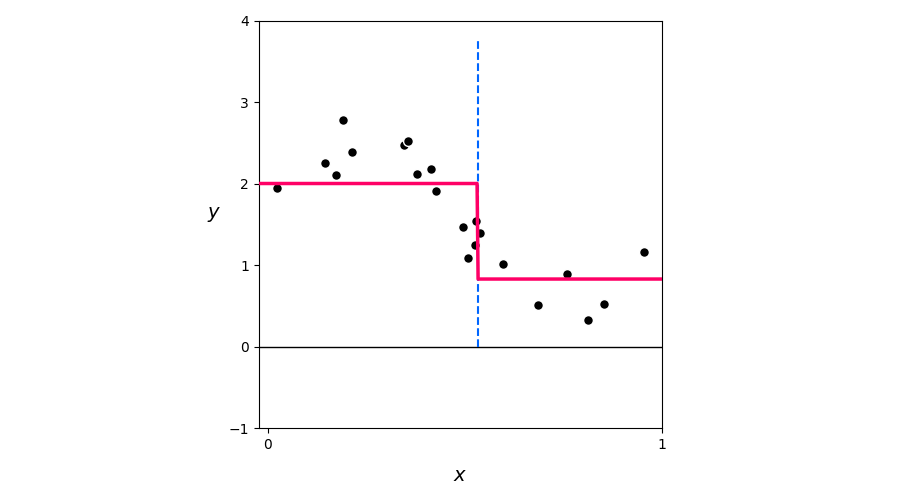
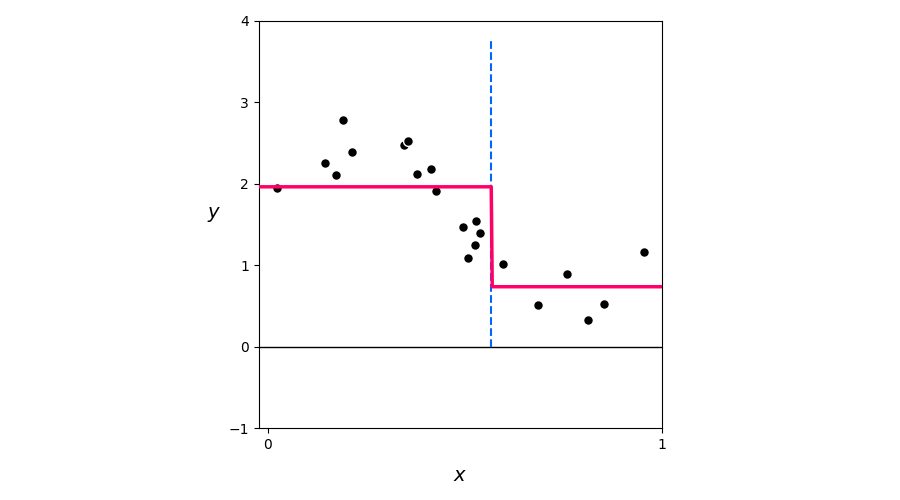
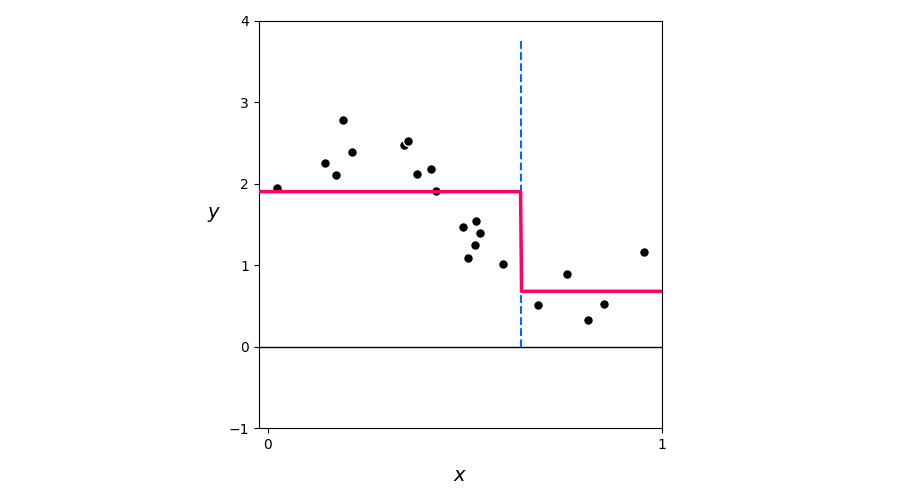
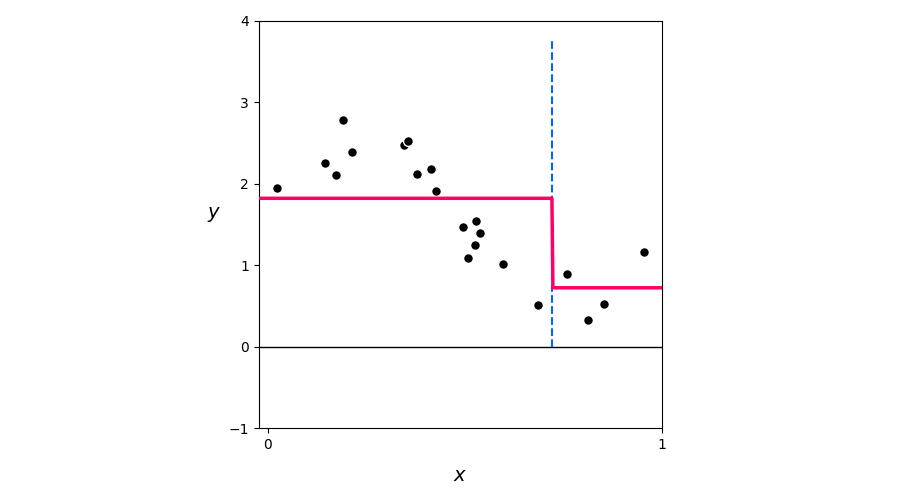
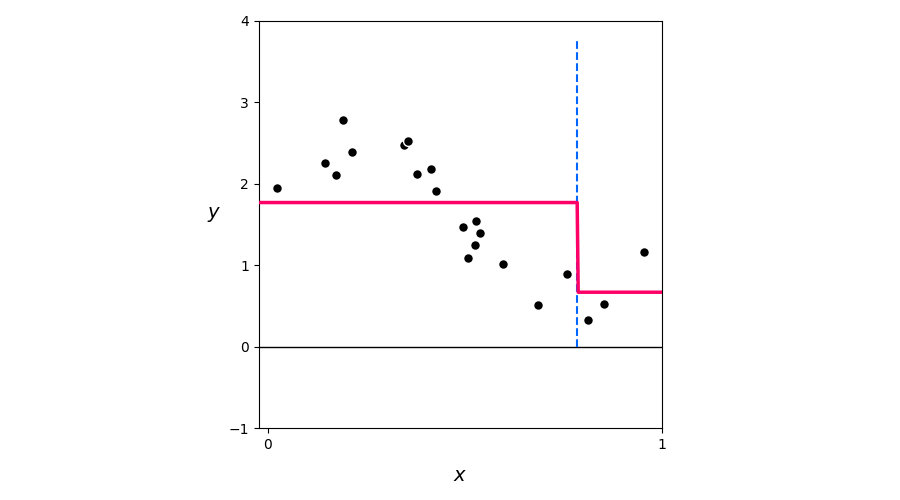
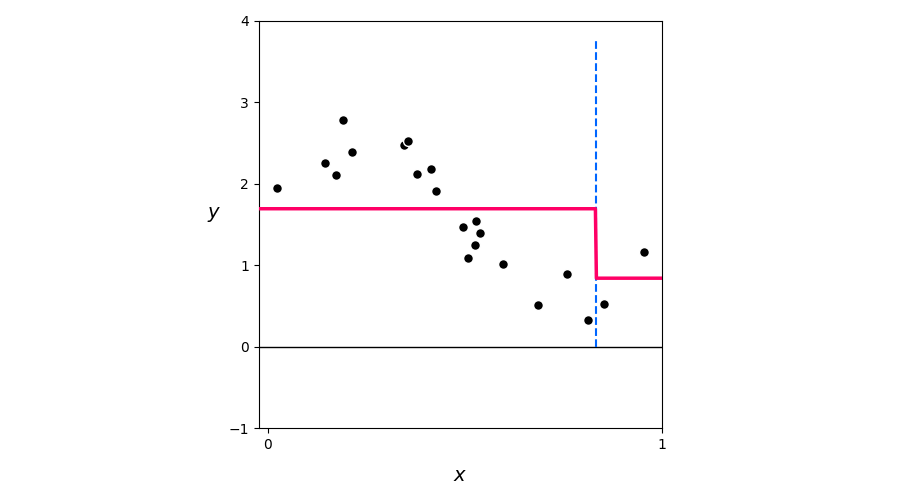
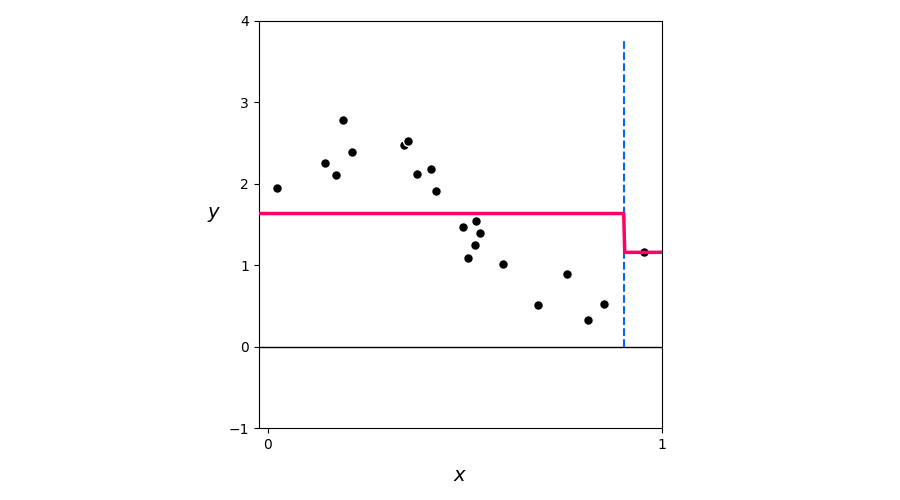

In [8]:
# animate stump collection for a sample dataset
demo = nonlib.stump_visualizer_2d.Visualizer()
csvname = datapath + 'noisy_sin_raised.csv'
demo.load_data(csvname)
demo.browse_stumps()

Mathematically we can write the $p^{th}$ stump as 

\begin{equation}
f_p(x) = \begin{cases} L_{p,1} \,\,\,\,\,\text{if} \,\,\,\, x \leq s_{p} \\ L_{p,2} \,\,\,\,\, \text{if} \,\,\,\, x > s_{p}.   \end{cases}  ~~~~~~~~
\end{equation}

whose split point is given as

\begin{equation}
s_p = \frac{x_p + x_{p+1}}{2}
\end{equation}

and corresponding levels computed as 

\begin{array}
\
L_{p,1} = \text{mean}\left\{y_j  \left.\phantom{\frac{.}{.}}\right\vert \,\,\, x_j \leq s_p\right\}\\
L_{p,2} = \text{mean}\left\{y_j \left.\phantom{\frac{.}{.}}\right\vert  \,\,\, x_j > s_p \right\}\\
\end{array}

Note that the data should be pre-sorted by input values $x_p$.

Also note: when we are dealing with a classification dataset we need only build a stump where successive points belong to two distinct classes, or in other words place a split point in between two successive points if they belong to different classes.  (Likewise with regression data we need only create a stump between consecutive inputs that have differeing output values.) We illustrate this below on a toy nonlinear classification dataset with single dimensional input.


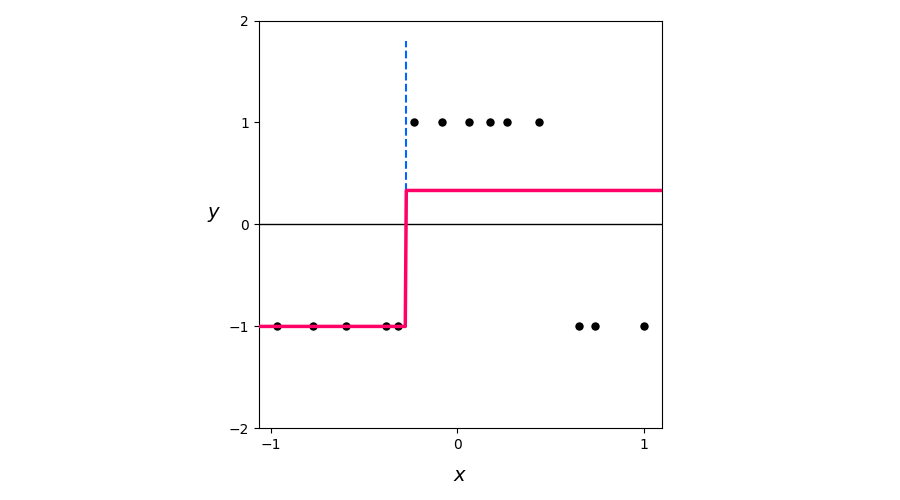
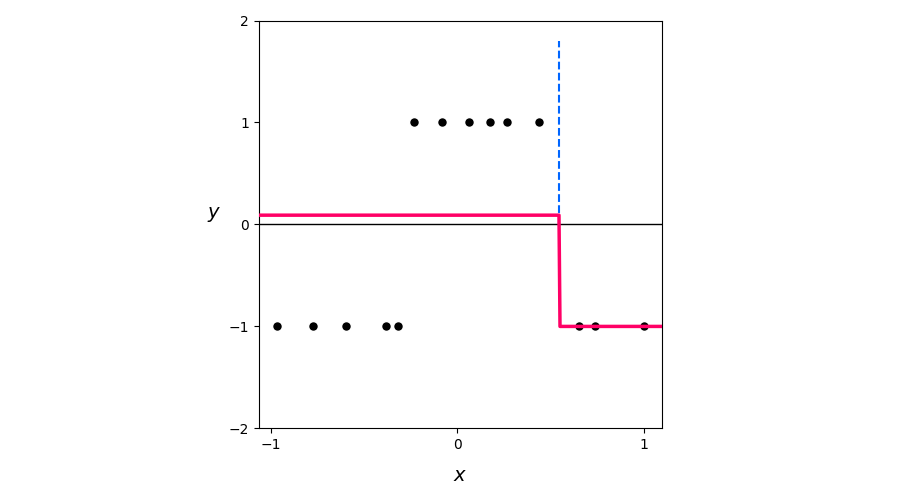

In [6]:
# animate stump collection for a sample dataset
demo = nonlib.stump_visualizer_2d.Visualizer()
csvname = datapath + 'signed_projectile.csv'
demo.load_data(csvname)
demo.browse_stumps()

More generally that for data whose input is $N$ dimensional we generate stumps like this along *each input dimension*.  That is for a dataset of $P$ points $\left \{\mathbf{x}_p,y_p \right \}_{p=1}^{P}$ where each $\mathbf{x}_p$ is $N$ dimensional, we generate the $p^{th}$ stump along the $n^{th}$ input dimension by defining its stump as

\begin{equation}
s_{p,n} = \frac{x_{p,\,n} + x_{p+1,\,n}}{2}
\end{equation}

and corresponding levels computed as 

\begin{array}
\
L_{p,n,1} = \text{mean}\left\{y_p  \left.\phantom{\frac{.}{.}}\right\vert \,\,\, x_{p,n} \leq s_{p,n}\right\}\\
L_{p,n,2} = \text{mean}\left\{y_p \left.\phantom{\frac{.}{.}}\right\vert  \,\,\, x_{p,n} > s_{p,n} \right\}.\\
\end{array}


Again with classification data we need only produce a stump between pairs of points whose output belong to different classes - likewise with regression data we need only create a stump between consecutive inputs that have differeing output values.  For a dataset of $P$ points with $N$ dimensional input this method will produce at most $P-1$ stumps along each input dimension, for a total of at most $N\cdot \left(P-1\right)$ stumps.

When the dimensionality / size of data becomes prohibitively large this naive approach to generating stumps / determining split points one can e.g., subsample these split points or use [distributional assumptions](http://xgboost.readthedocs.io/en/latest/model.html) on the dataset itself to generate fewer split points.  Nonetheless, the naive method detailied here very adequate for many cases.

### Naive stump generating pseudo-code (used for both regression and classification)

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>Input:</strong> dataset $\left \{\mathbf{x}_p,y_p \right \}_{p=1}^{P}$  whose input is $N$ dimensional <br>


<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,n = 1...N$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>sort</code> data along $n^{th}$ axis based on values of $x_{p,n}$ <br>


<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $p=1...P-1$ <br>


<strong>5:
</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>if</code> $y_p \neq y_{p+1}$ <br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; create / store split point $s_{p,n} = \frac{x_{p,\,n} + x_{p+1,\,n}}{2}$ and levels $\begin{smallmatrix}
L_{p,n,1}\, = \,\text{mean}\left\{y_p  \left.\phantom{\frac{.}{.}}\right\vert \,\,\, x_{p,n} \leq s_{p,n}\right\}\\
L_{p,n,2}\, = \,\text{mean}\left\{y_p \left.\phantom{\frac{.}{.}}\right\vert  \,\,\, x_{p,n} > s_{p,n} \right\}\end{smallmatrix}
$
<br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> end for</code> <br>

<strong>8:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>9:</strong>&nbsp;&nbsp; <strong>output:</strong> split points and levels of all stumps <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>


Below we provide a short implementation of this pseduo-code in Python.

In [36]:
def create_stumps(x,y):
    '''
    Create stumps tailored to an input dataset (x,y) based on the naive method of creating
    a split point between each pair of successive inputs.  
    
    The input to this function: a dataset (x,y) where the input x has shape 
    (NUMBER OF POINTS by  DIMENSION OF INPUT)
    
    The output of this function is a set of two lists, one containing the split points and 
    the other the corresponding levels of stumps.
    '''
    
    # containers for the split points and levels of our stumps, along with container
    # for which dimension the stump is defined along
    splits = []
    levels = []
    dims = []
    
    # important constants: dimension of input N and total number of points P
    N = np.shape(x)[1]              
    P = len(y)

    ### begin outer loop - loop over each dimension of the input
    for n in range(N):
        # make a copy of the n^th dimension of the input data (we will sort after this)
        x_n = copy.deepcopy(x[:,n])
        y_n = copy.deepcopy(y)
        
        # sort x_n and y_n according to ascending order in x_n
        sorted_inds = np.argsort(x_n,axis = 0)
        x_n = x_n[sorted_inds]
        y_n = y_n[sorted_inds]
        for p in range(P - 1):
            # determine if we split between consecutive points (if they belong to different classes / have different output)
            if y_n[p] != y_n[p+1]:
                # compute and store split point
                split = (x_n[p] + x_n[p+1])/float(2)
                splits.append(split)

                # gather output points to left and right of split
                output_left  = y_n[:p+1] 
                output_right = y_n[p+1:]
            
                # compute average on each side, assign to levels
                ave_left = np.mean(output_left)
                ave_right = np.mean(output_right)
                levels.append([ave_left,ave_right])
                
                # remember the dimension this stump is defined along
                dims.append(n)
                
    # return items
    return splits,levels,dims

# 2. Gradient boosting

Having generated a set of $U$ stumps $f_1,\,f_2,...,\,f_U$ in a manner like that detailed above, we can now think about how to best fit them to a given dataset.  By their very nature stumps are *un-ordered*, that is they do not increase in complexity (as e.g., polynomials do as we increase their degree, or neural networks do as we increase their depth) as we range over them.  Additionally they are also fixed in shape, unlike a neural network or adjustable basis, meanining that it matters considerably which we add to a working model.  These two qualities together mean that fitting a (complete) set of trees simultaneously to a dataset is rarely a good idea - as it will result in overfitting.  That is, if we fit the linear combination of every stump to the data using the ``predict`` function (see previous posts in this series if this notation is unfamiliar)

\begin{equation}
\text{predict}(\mathbf{x},\omega) = w_0\,f_0\left(\mathbf{x}\right) + w_1\,f_1\left(\mathbf{x}\right) + w_2\,f_2\left(\mathbf{x}\right) + \cdots + w_U\,f_U\left(\mathbf{x}\right)
\end{equation}

where here for notational nicety we have written the bias as a trivial stump $f_0\,\left(\mathbf{x}\right) = 1$ as well.

Then we will tune all $U+1$ weights - if we are performing regression - by minimizing the Least Squares error over all $P$ points as 

\begin{equation}
\sum_{p=1}^{P}\left(\text{predict}(\mathbf{x}_p,\omega) - y_p \right)^2.
\end{equation}

or if performing classification - by minimizing e.g., the logistic / softmax cost

\begin{equation}
\sum_{p=1}^{P}\text{log}\left(1 + e^{-y_p\,\text{predict}(\mathbf{x}_p,\omega)}\right)
\end{equation}

In either case, the result of doing this will be that we severely overfit our dataset.  We illustrate this in the example below.

But if we do not want to fit all of stumps together at once, which trees should we combine in order to produce an effective representation for a dataset?

#### <span style="color:#a50e3e;">Example 1. </span>   Fitting all stumps to a dataset simultaneously leads to severe overfitting

In this brief example we show how fitting all stumps generated for a dataset together simultaneously leads to over fitting using the sinsuoidal dataset used in the previous demonstrations.

<IPython.core.display.Javascript object>


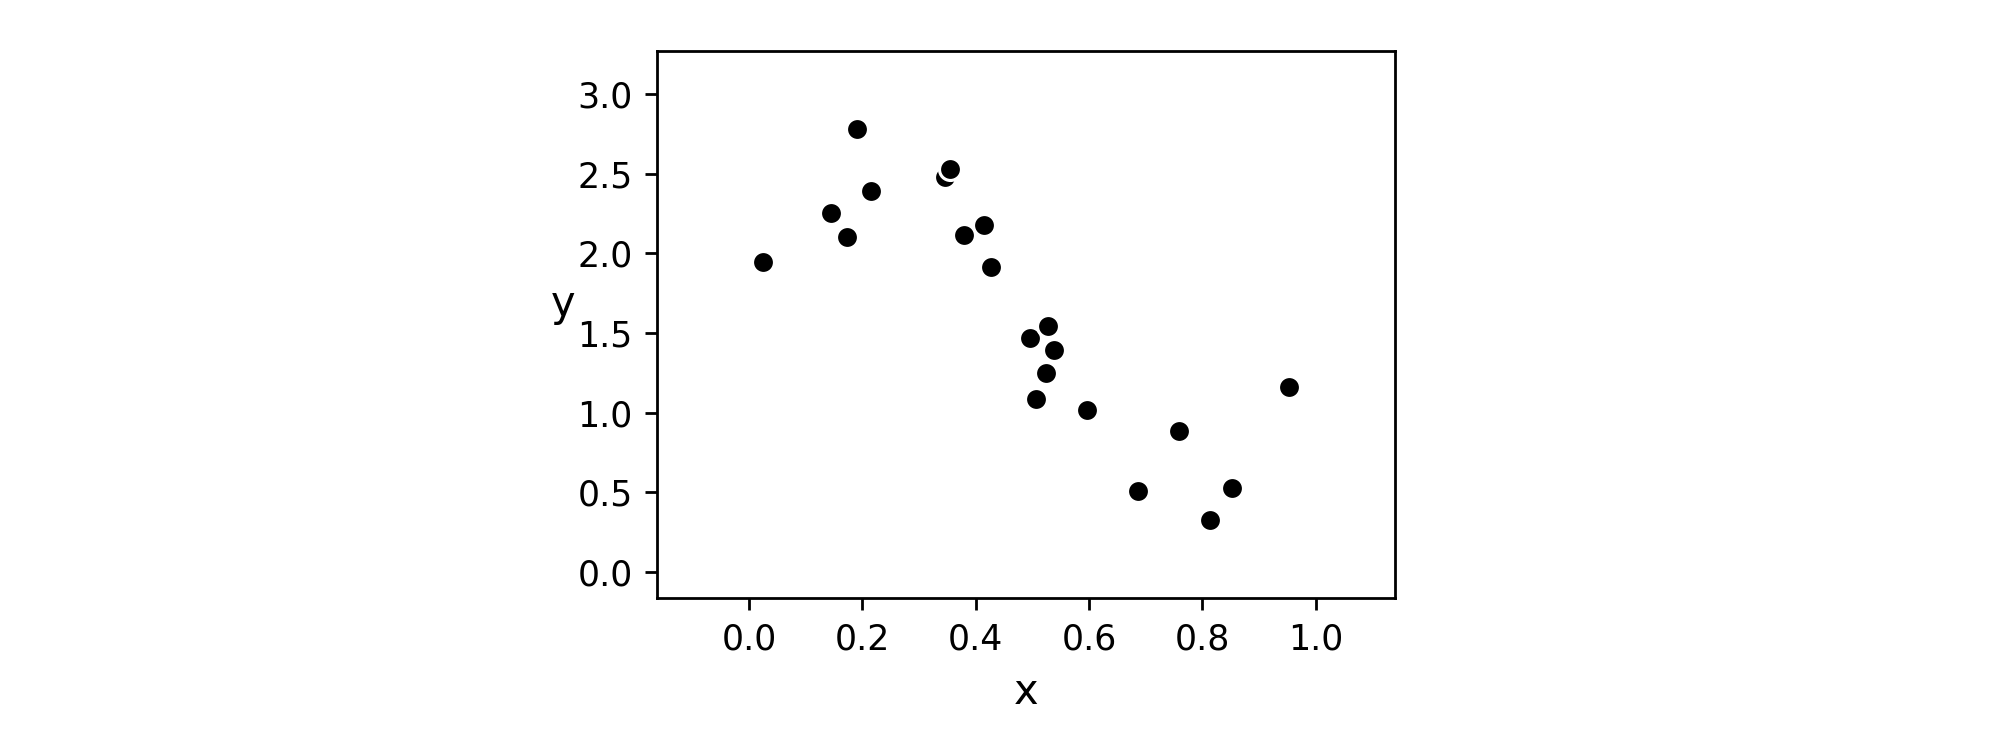

In [108]:
# create instance of linear regression demo, used below and in the next examples
demo1 = nonlib.nonlinear_regression_visualizer.Visualizer(csvname = datapath + 'noisy_sin_raised.csv')
demo1.plot_data(xlabel = 'x',ylabel = 'y')

We first generate the set of stumps for this dataset - this is the same set shown in the first animation of the previous Section.  We use the ``make_stumps`` function defined previously to do this.

In [111]:
# create stumps for this dataset
x = demo1.x; y = demo1.y;
splits,levels,dims = create_stumps(x,y)

With our stumps defined in terms of their ``splits`` and ``levels`` we can now construct a ``predict`` function in Python, as well as a ``least_squares`` function.  We do this below.

In [112]:
# tree prediction
def predict(pt,w): 
    # initialize return value and add bias weight
    val = 0
    val += w[0]
    
    # loop over the stump collectionand calculate weighted contribution
    for u in range(len(splits)):
        # get current stump f_u
        split = splits[u]
        level = levels[u]

        ### our stump function f_u(x)
        if pt <= split:  # lies to the left - so evaluate at left level
            val += w[u+1]*level[0]
        else:
            val += w[u+1]*level[1]
    return val

# a standard Least Squares function
def least_squares(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p]
        y_p = y[p]
        cost +=(predict(x_p,w) - y_p)**2
    return cost

Since the prediction function here has no internal parameters that need tuning, the Least Squares cost function is convex and - since it is also a quadratic function - it can be solved using a single [Newton step](https://jermwatt.github.io/mlrefined/blog_posts/Mathematical_Optimization/Part_5_Newtons_method.html) (i.e., by solving the 'normal equations').  We do this in the next Python cell.

In [113]:
# declare an instance of our current our optimizers
opt = nonlib.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_init = np.zeros((len(splits)+1,1))
w_best = opt.newtons_method(g = least_squares,win = w_init,max_its = 1,output = 'best')

With our weights tuned we can plot the resulting model - which overfits our dataset!

<IPython.core.display.Javascript object>


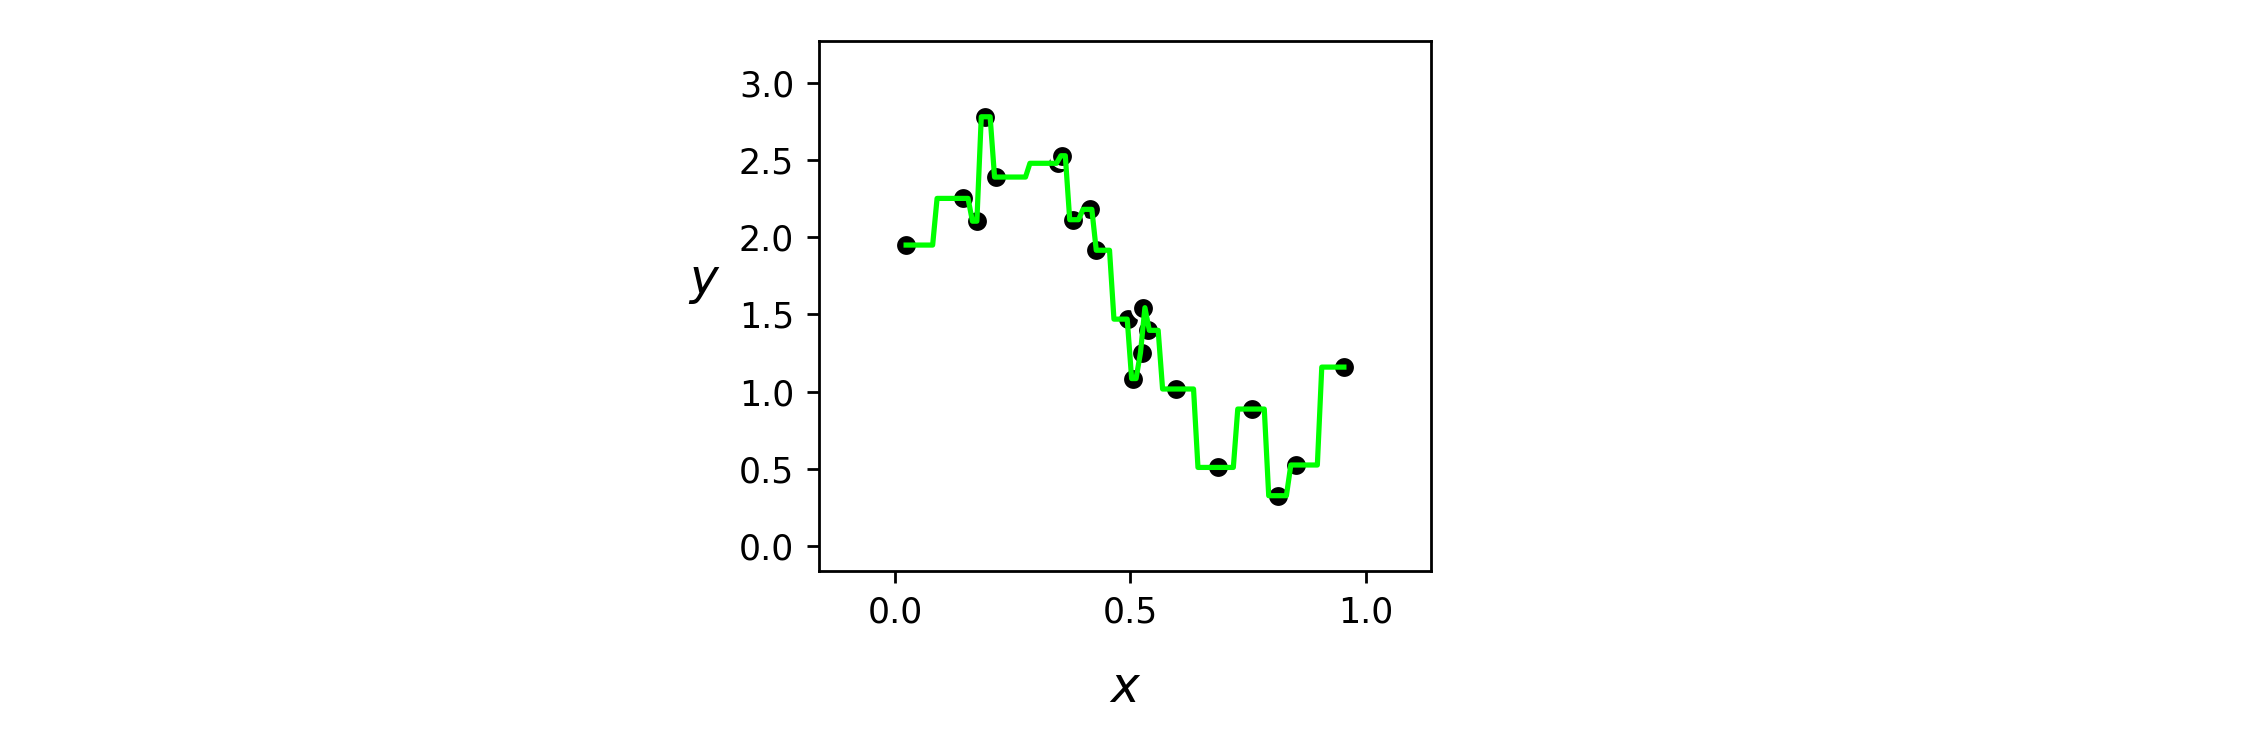

In [114]:
# static transform image
demo1.static_img(w_best,least_squares,predict)

## 2.1  The big picture

As a way of fitting combinations of stumps to a dataset boosting methods take a greedy approach in which one stump at a time (the best one at that moment) is added to a working model (consisting of a linear combination of previously used stumps) of the data.  This is a natural way of controlling the amount and quality of nonlinearity produced via a linear combination of our un-ordered fixed-shape stumps.  

In the next cell we show the gradient boosting fit of stumps to the toy dataset we used above in illustrating how stumps themselves are generated.  In particular we show the boosting fit over a range of stump units, which can be adjusted by moving the slider left and right.  In the left panel of this animation the original dataset is shown, along with the current best stump being added to the model.  In the middle panel the current moodel - linear combination of stumps - is shown in green along with the dataset.  In the right panel the lesat squares cost function value corresponding to the current model is shown.


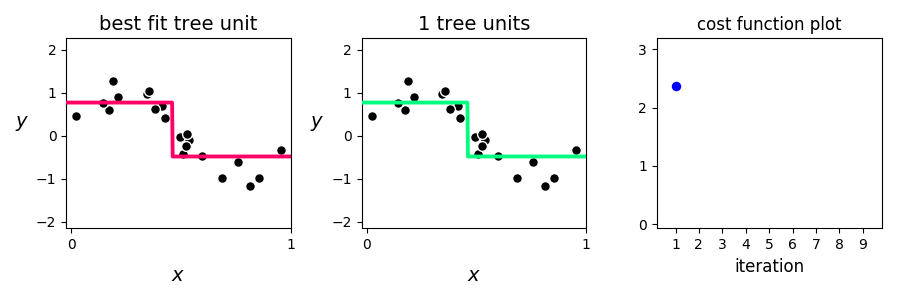
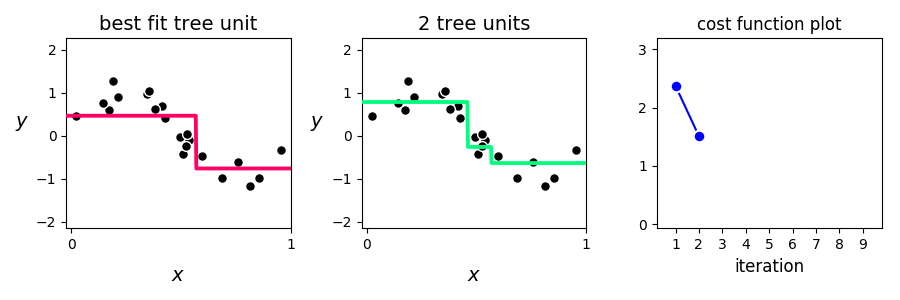
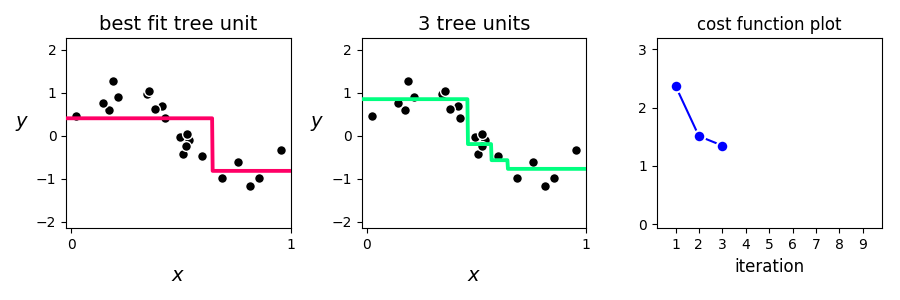
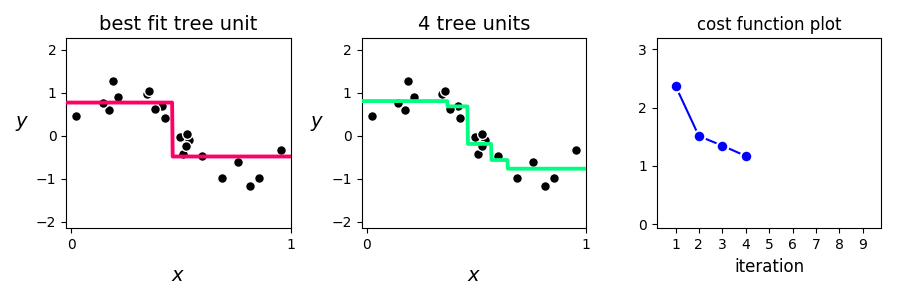
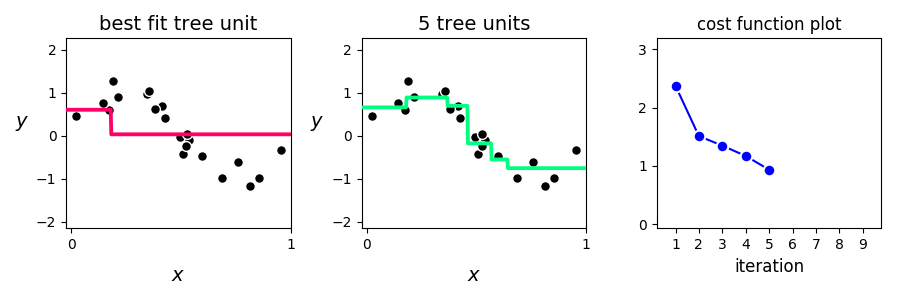
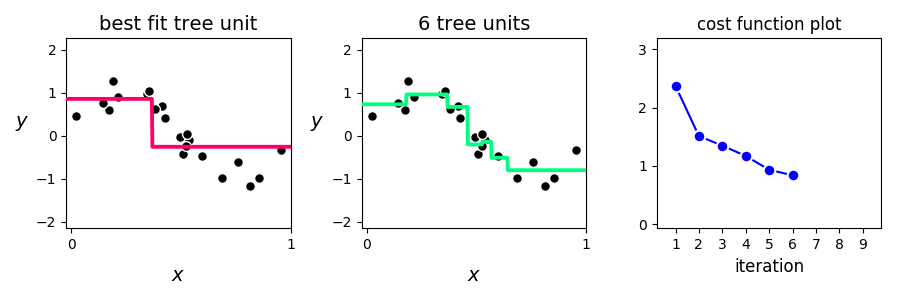
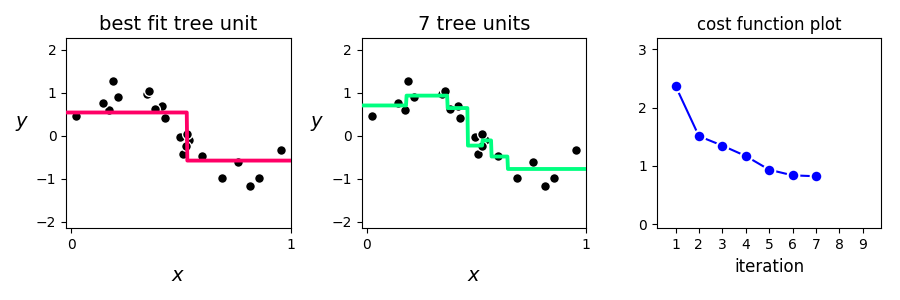
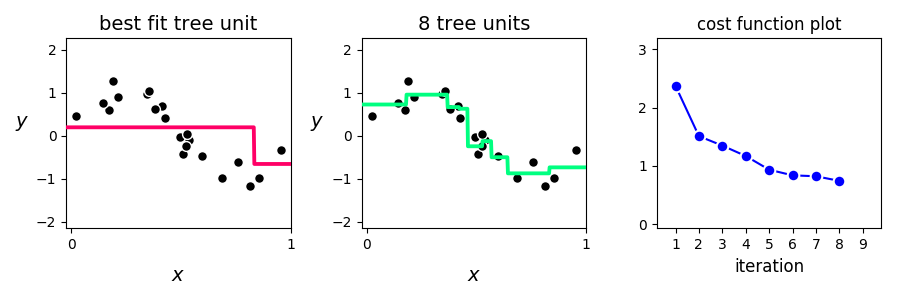
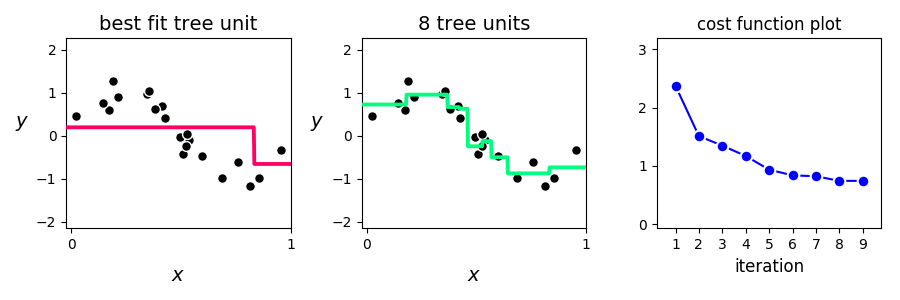

In [22]:
# an animation illustrating gradient boosting fit to a regression dataset
demo = nonlib.regression_basis_single.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo.load_data(csvname)
demo.brows_single_fit(basis='tree',num_units = [v for v in range(1,10)])

Next we show an analogous version of the animator above for two class classification, where the input is single dimensional. Here we use the dataset shown in the previous Section, since it has only two stumps the fit is perfected quite rapidly.


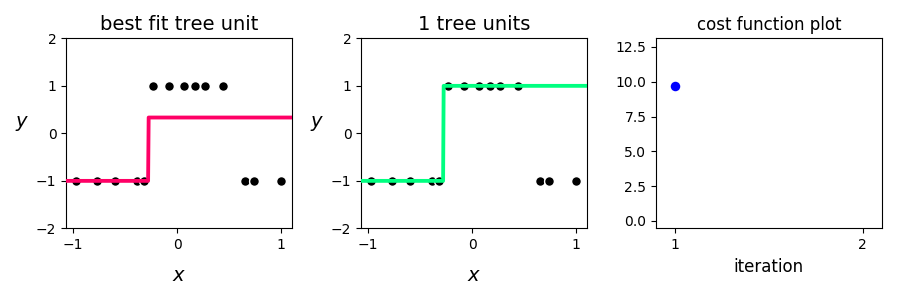
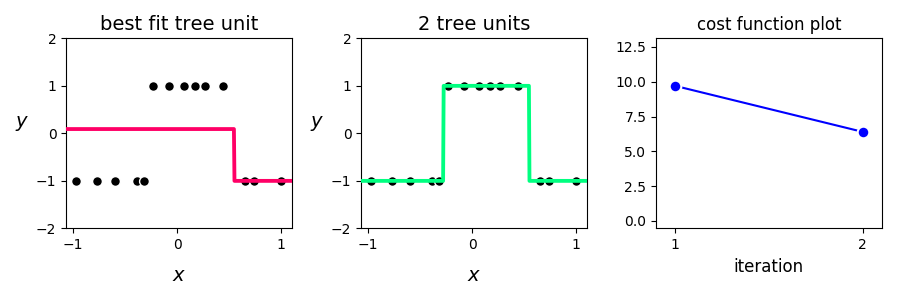

In [29]:
# an animation illustrating gradient boosting fit to a regression dataset
demo = nonlib.classification_basis_single.Visualizer()
csvname = datapath + 'signed_projectile.csv'
demo.load_data(csvname)
demo.brows_single_fit(basis='tree',num_units = [v for v in range(1,3)])


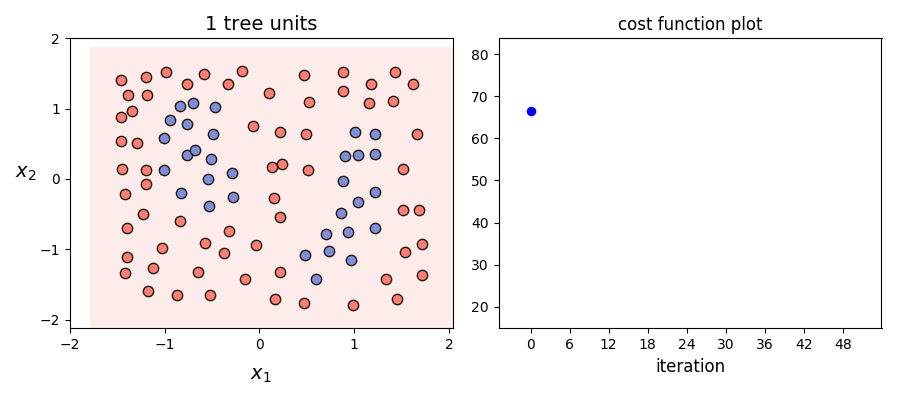
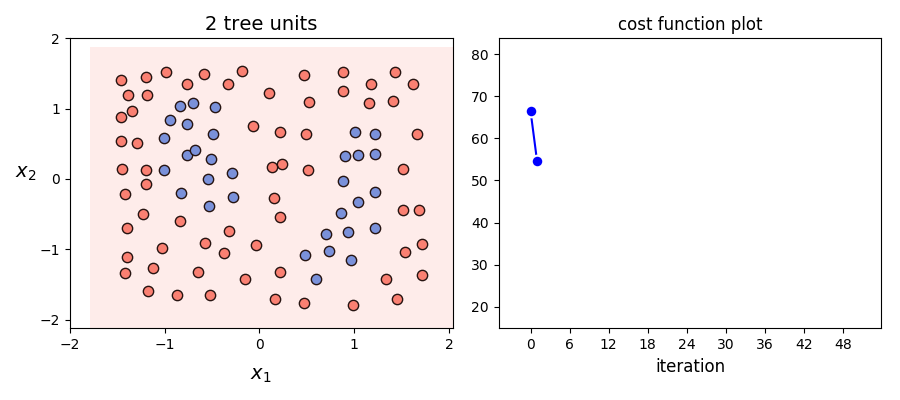
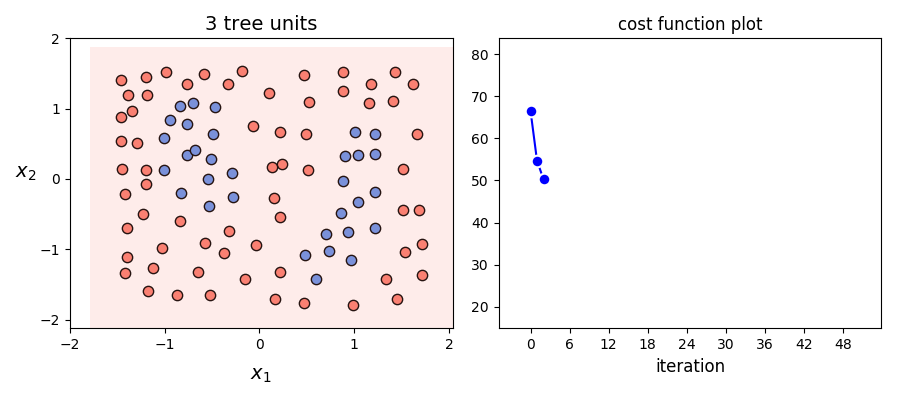
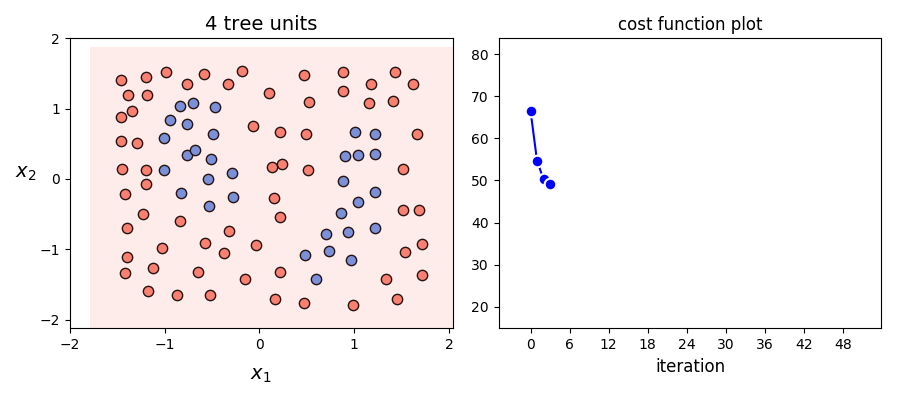
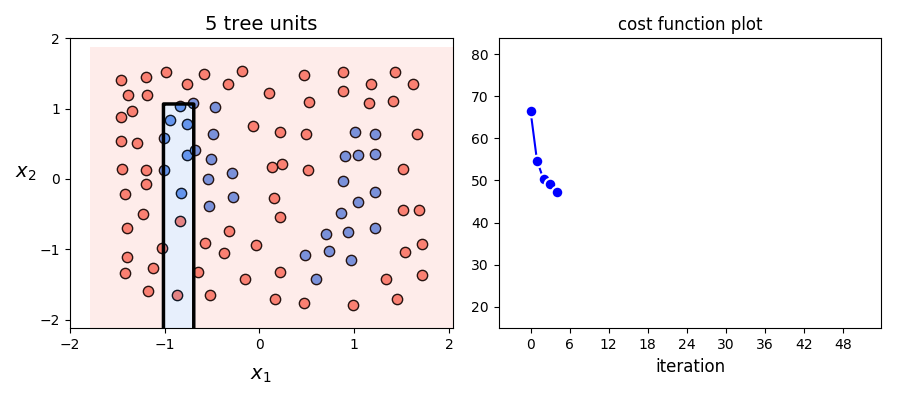
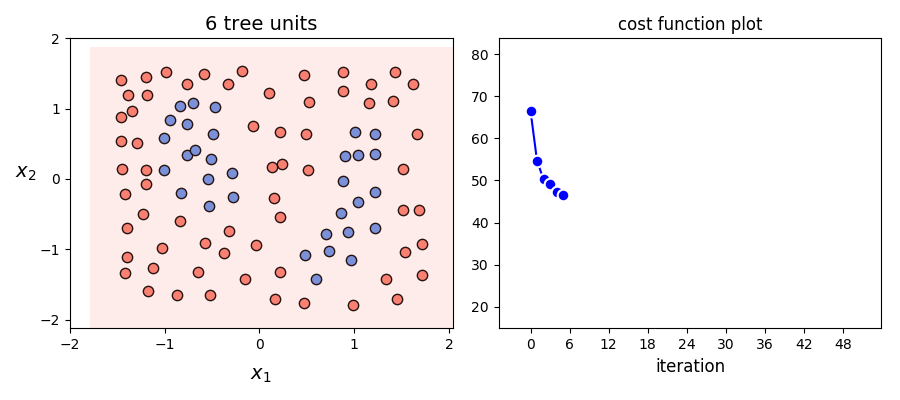
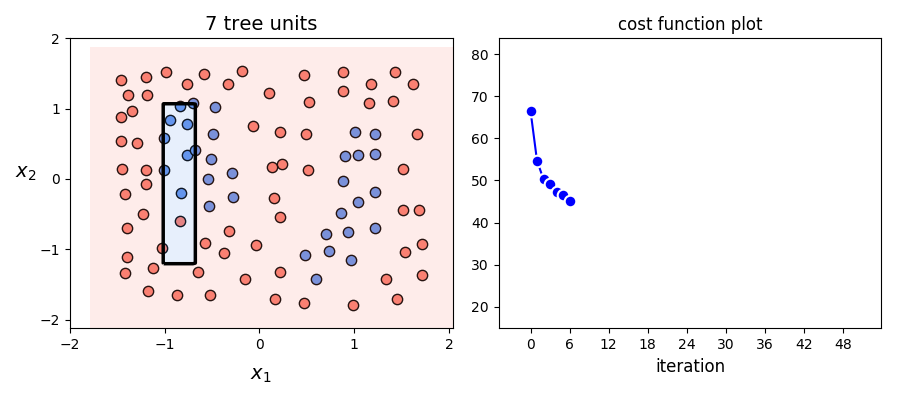
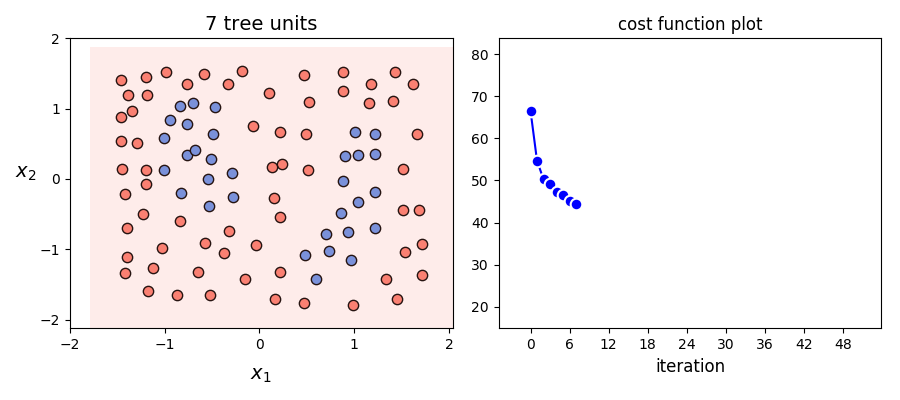
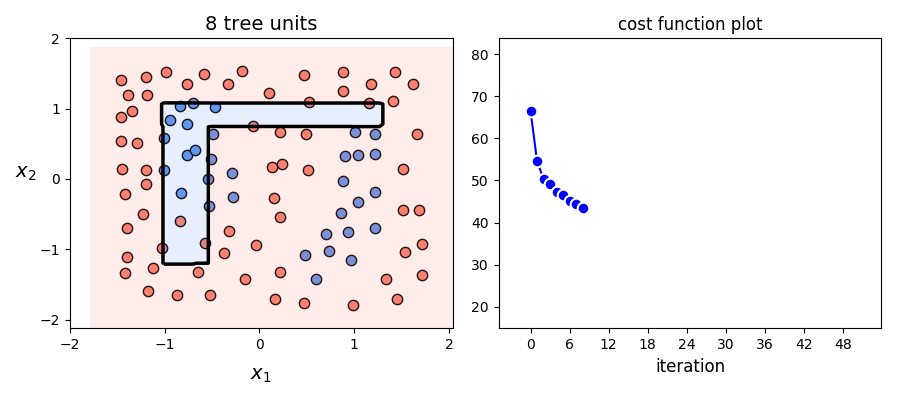
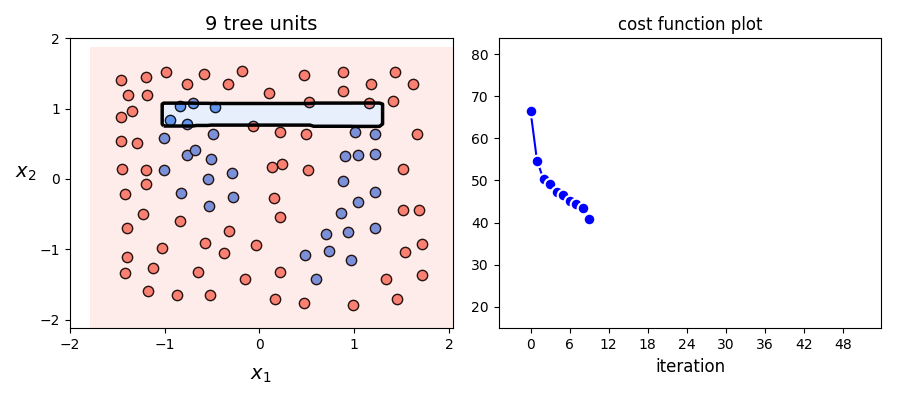
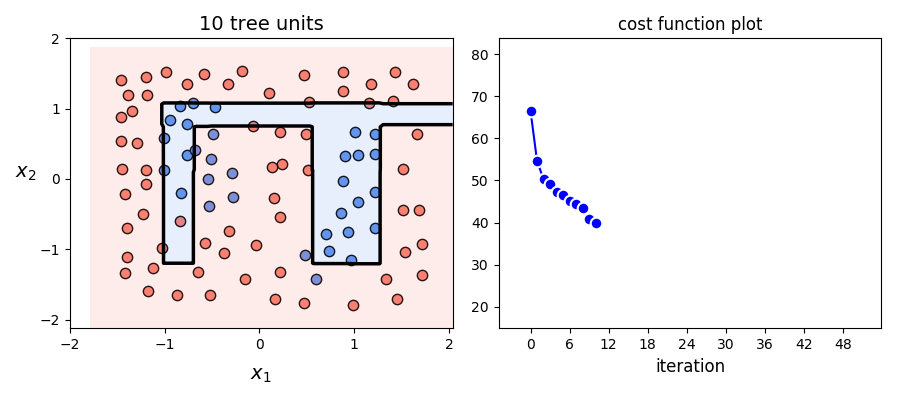
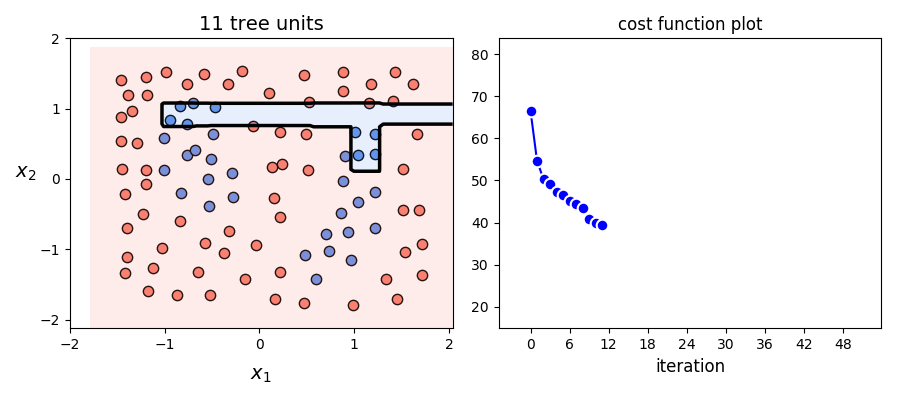
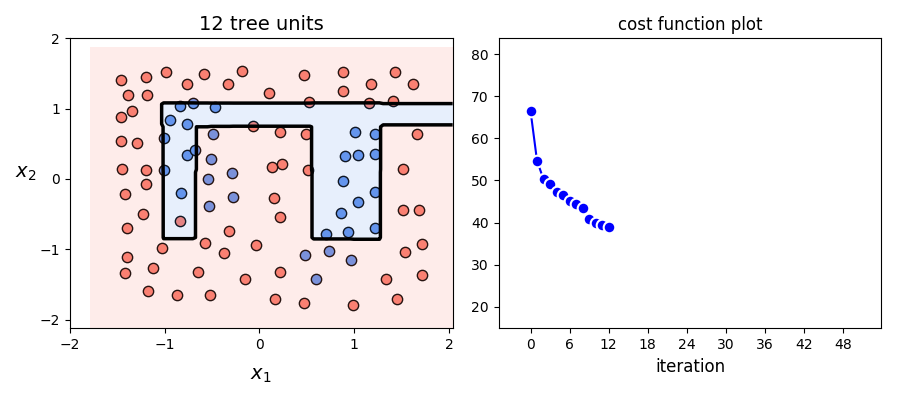
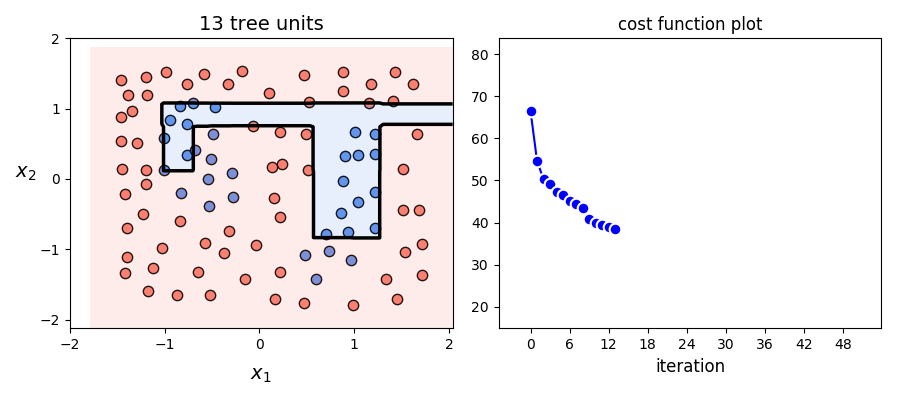
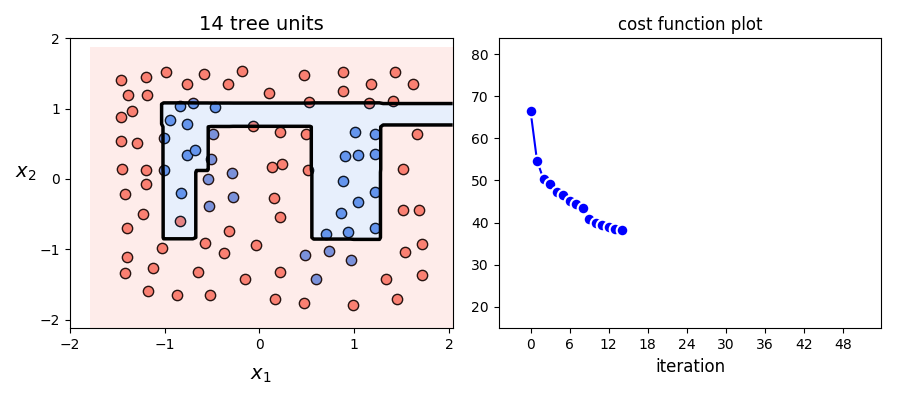
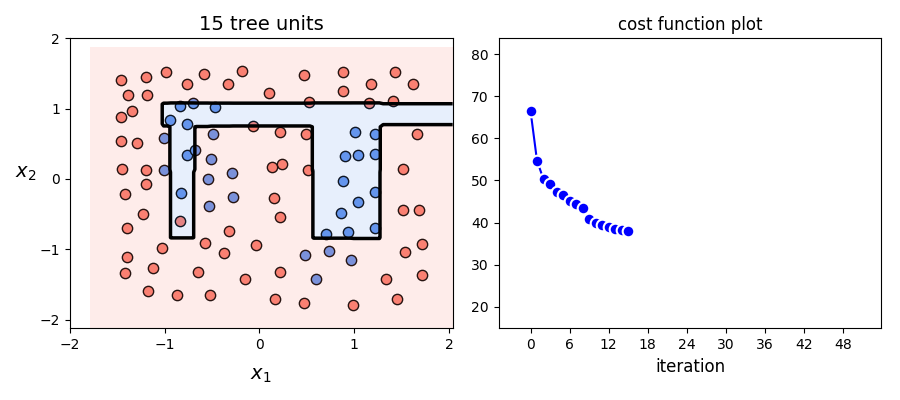
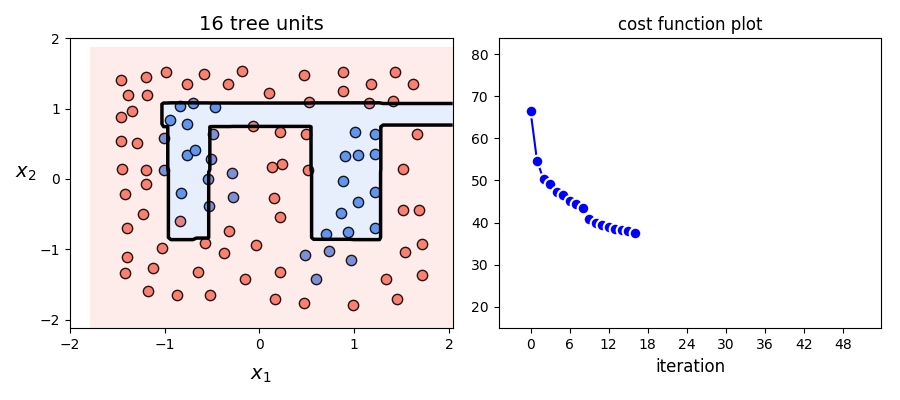
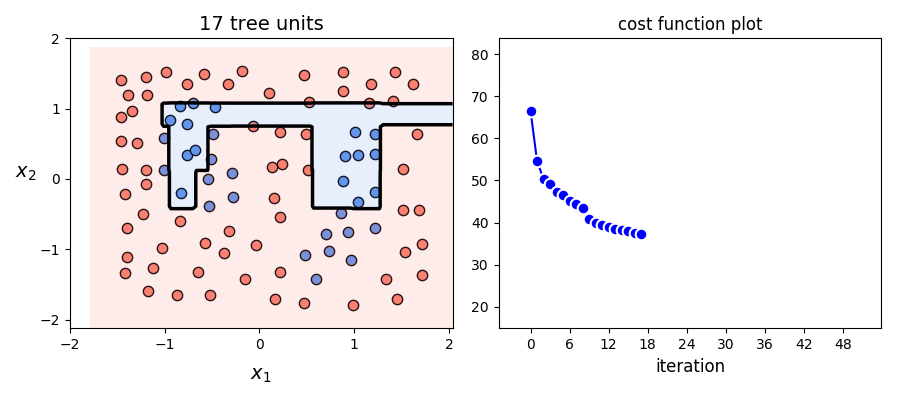
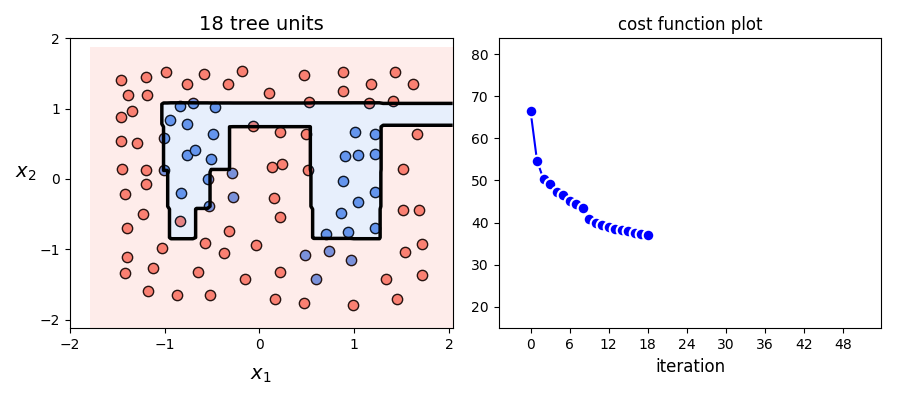
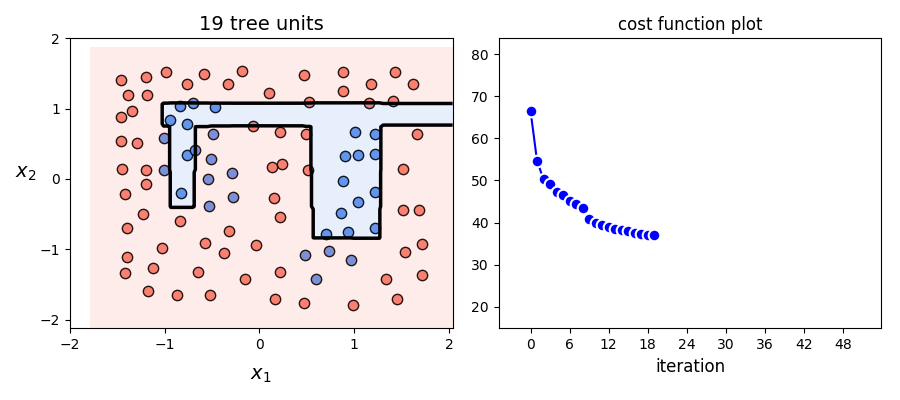
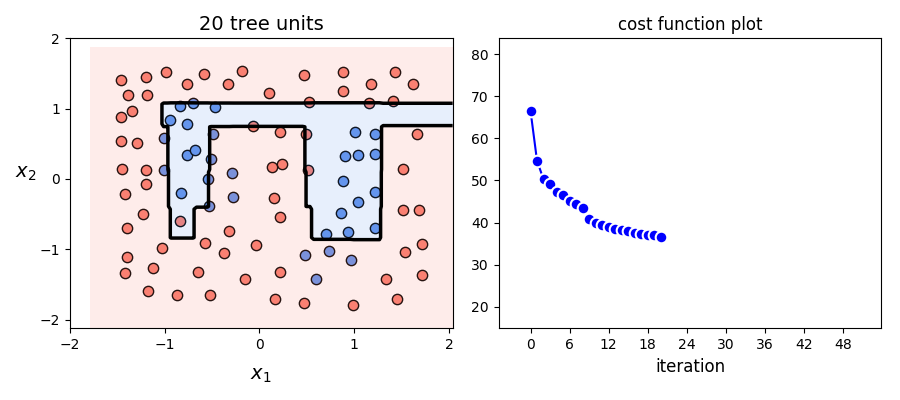
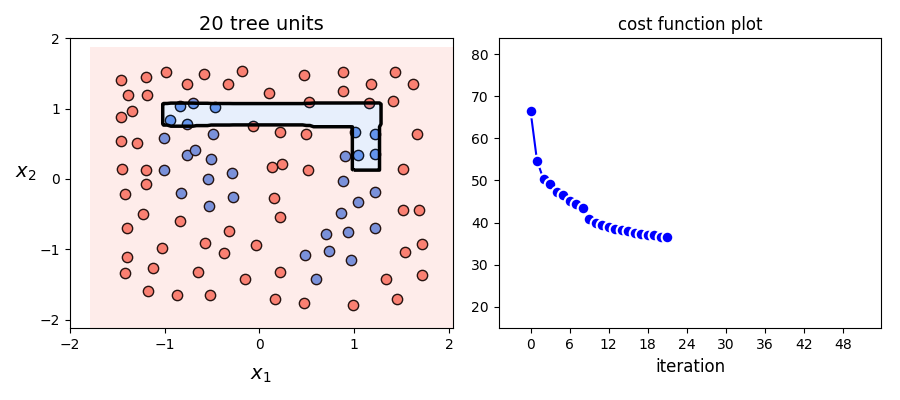
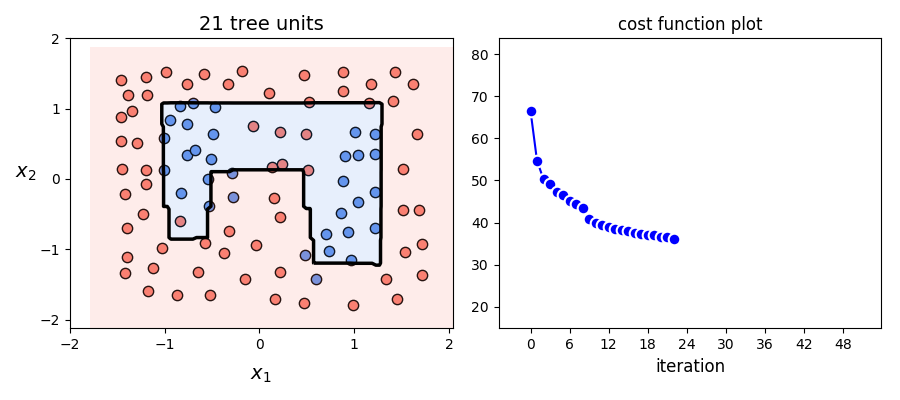
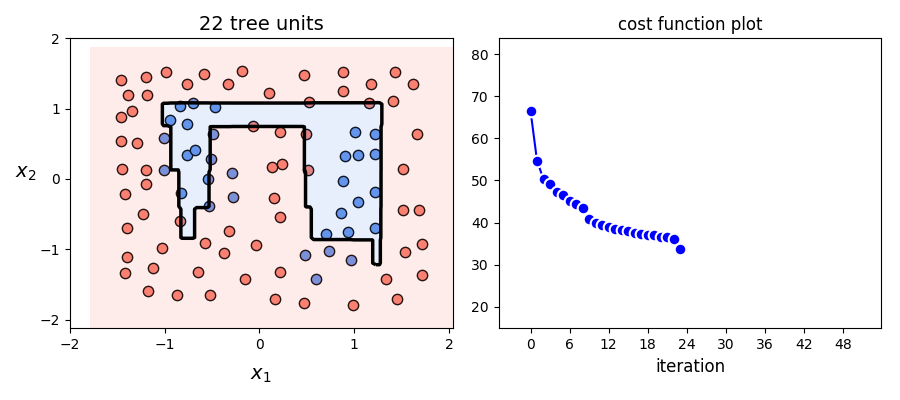
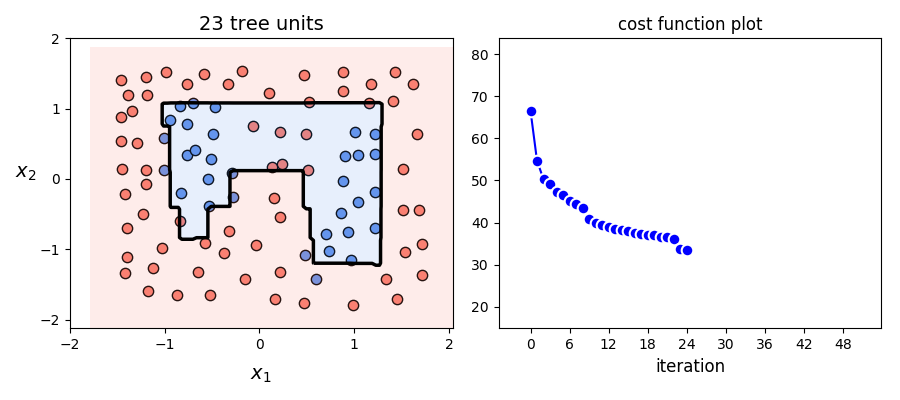
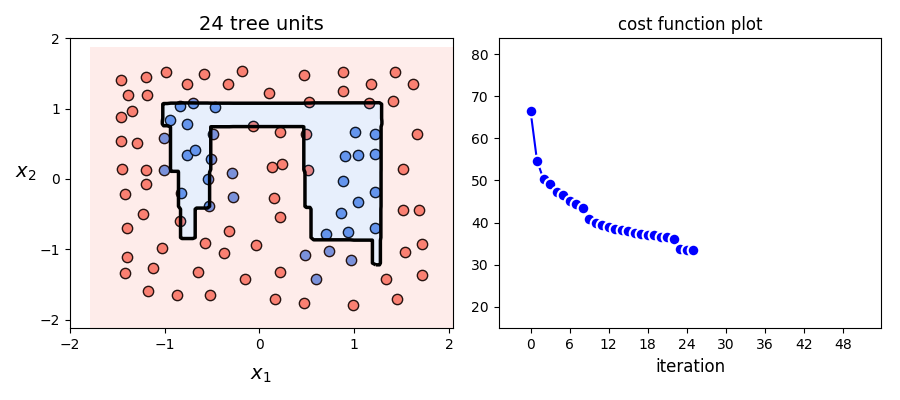
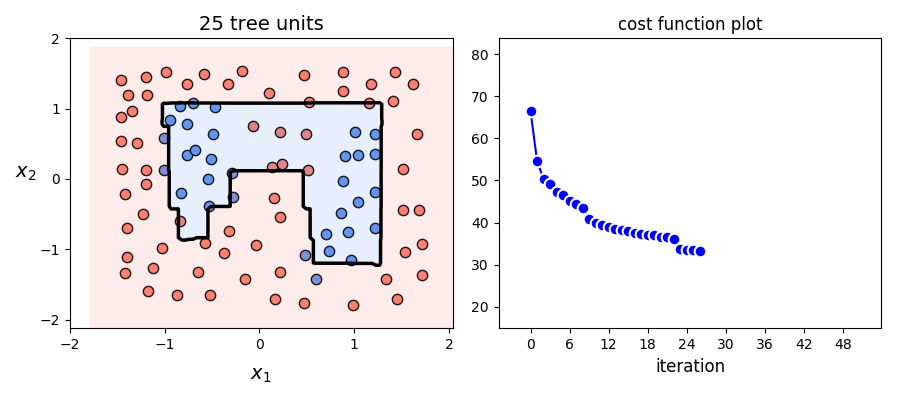
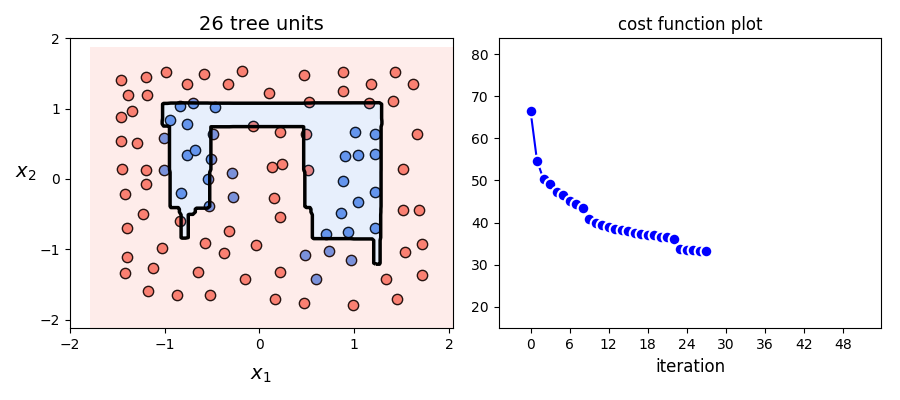
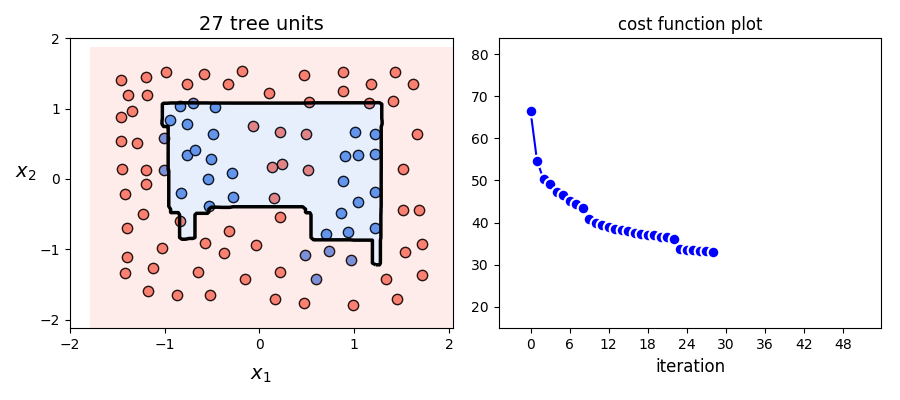
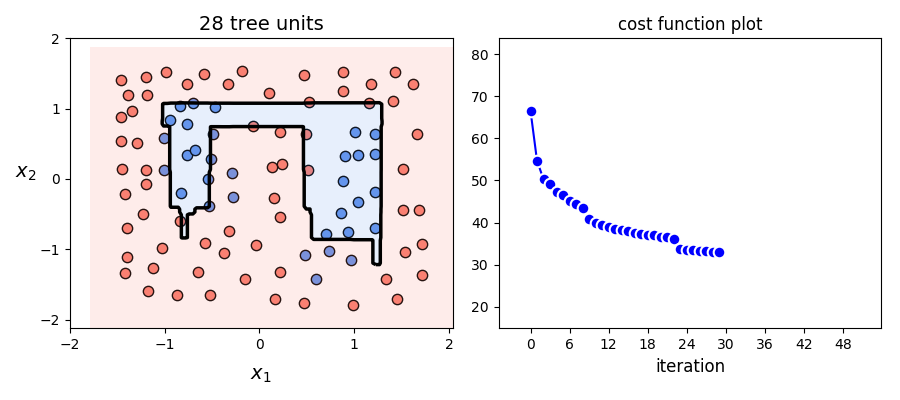
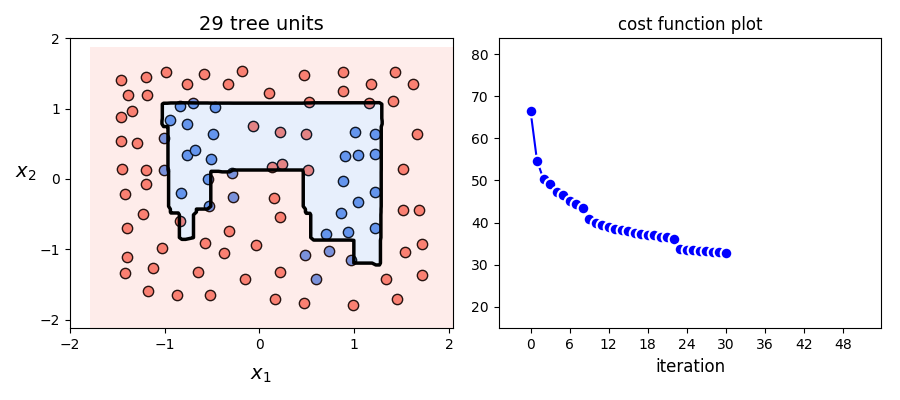
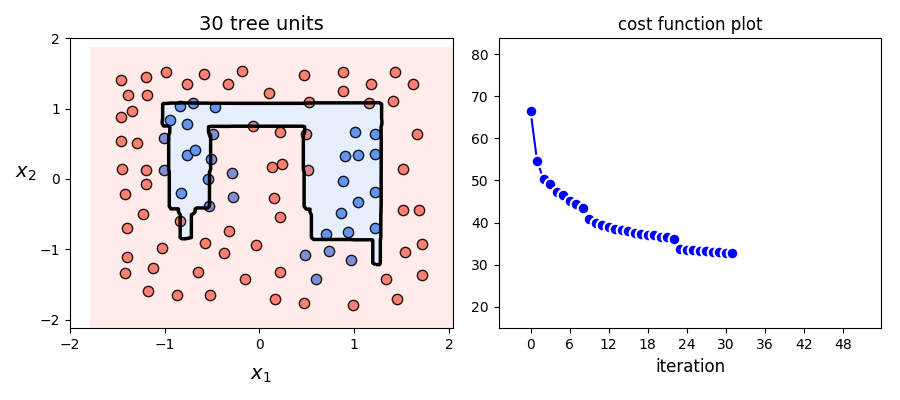
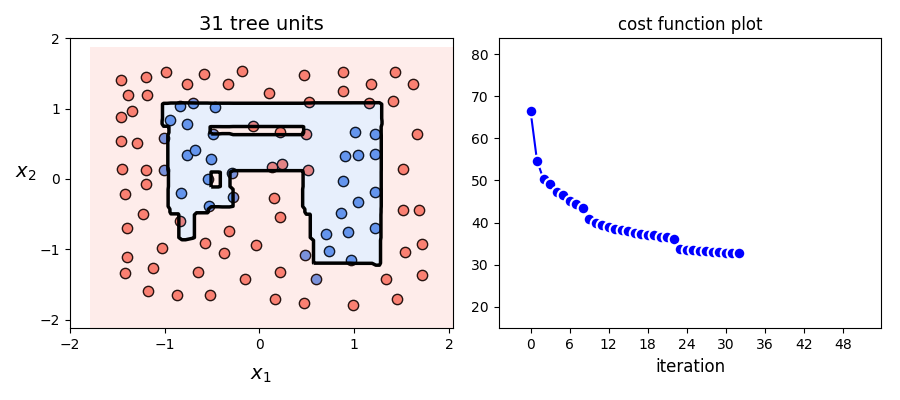
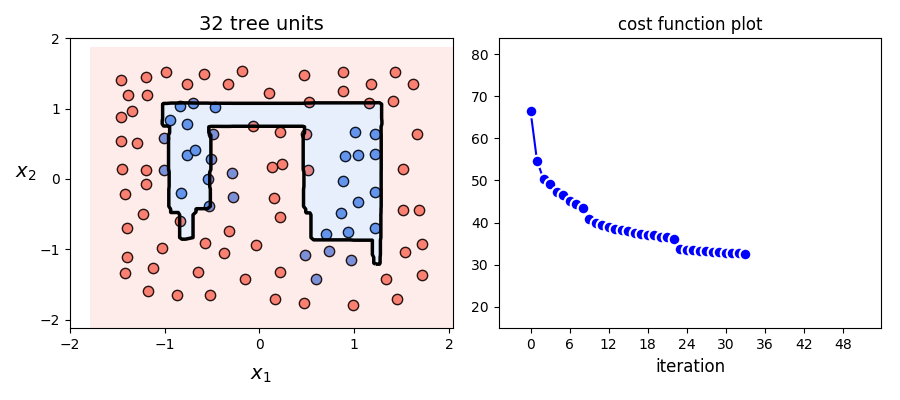
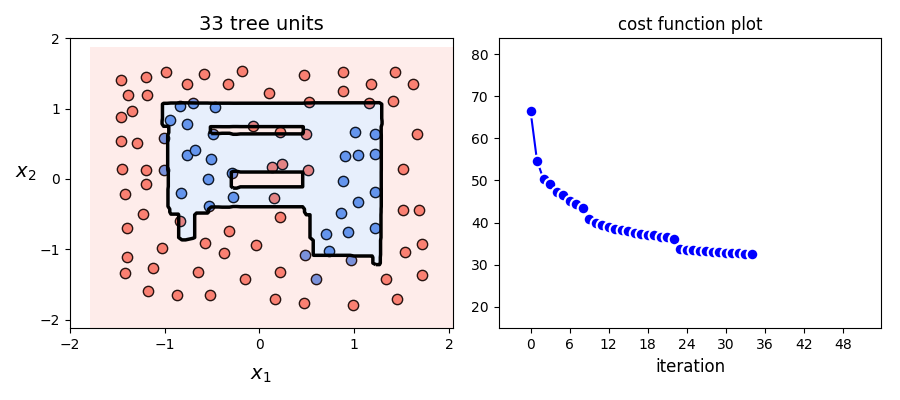
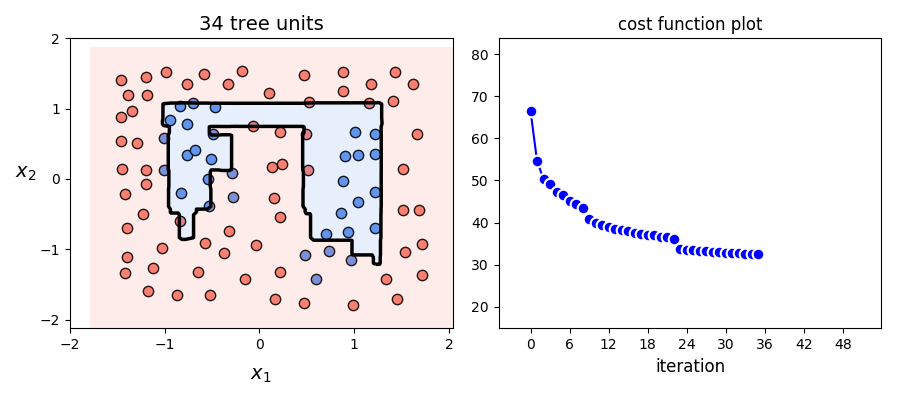
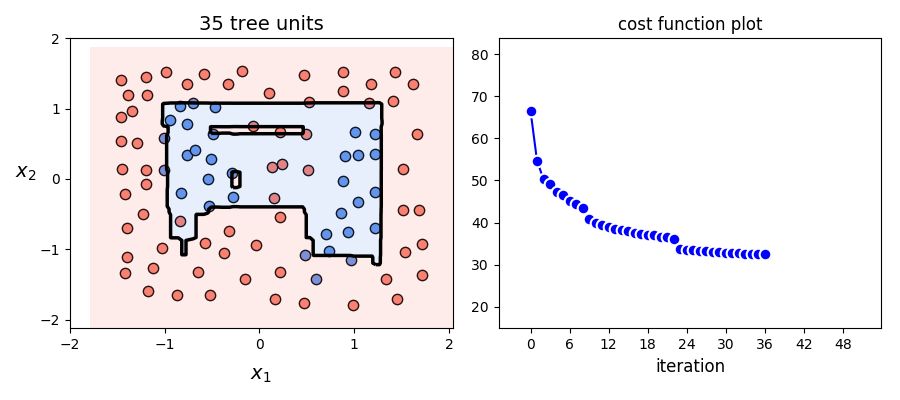
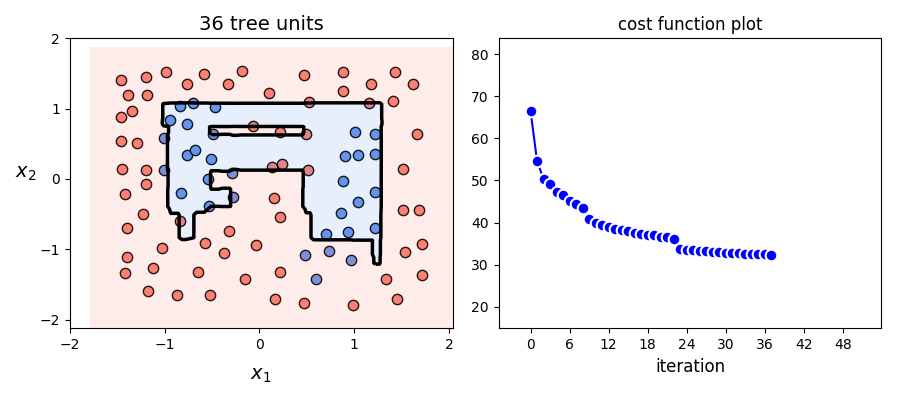
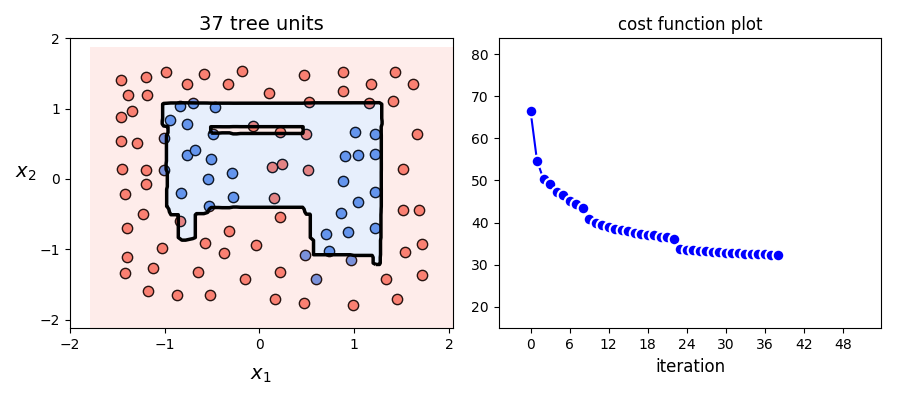
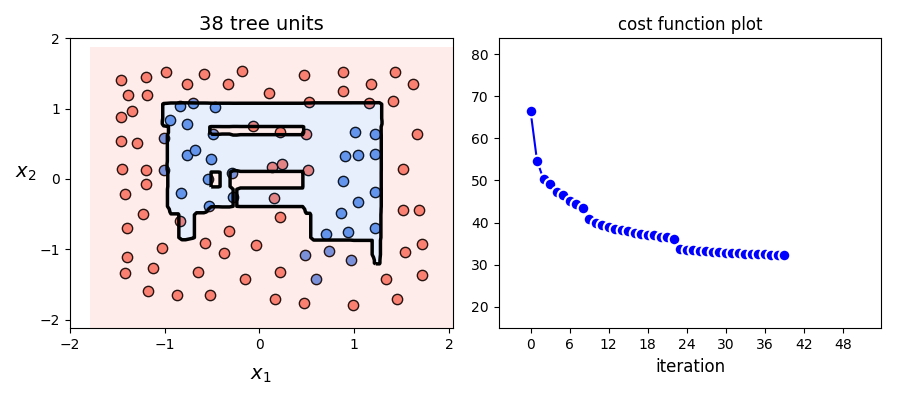
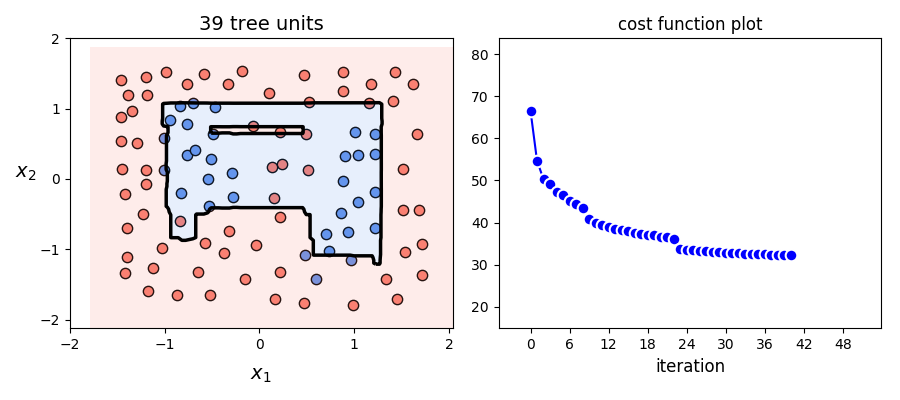
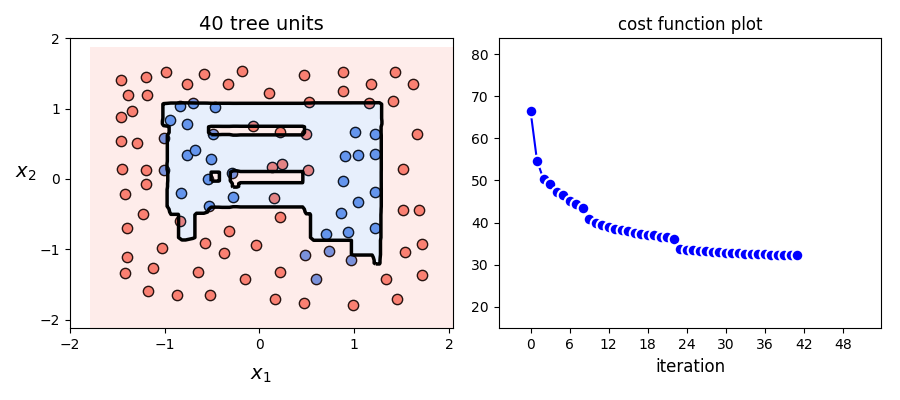
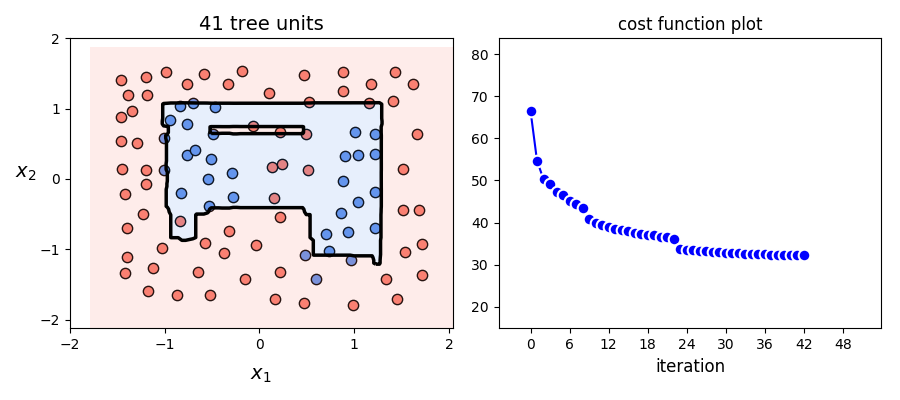
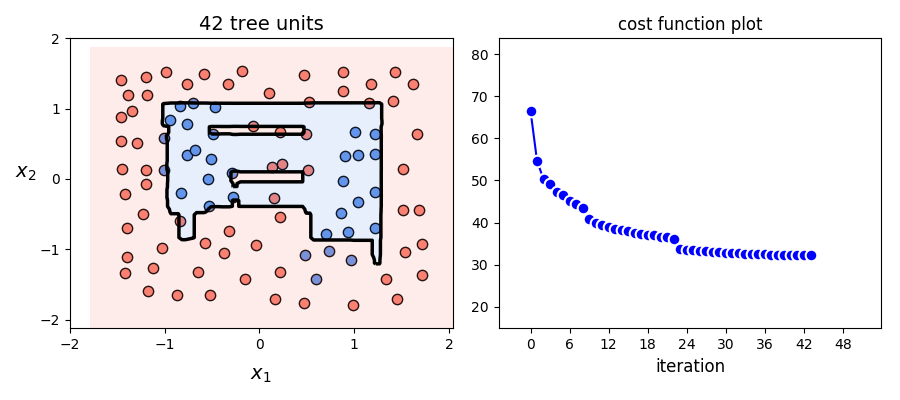
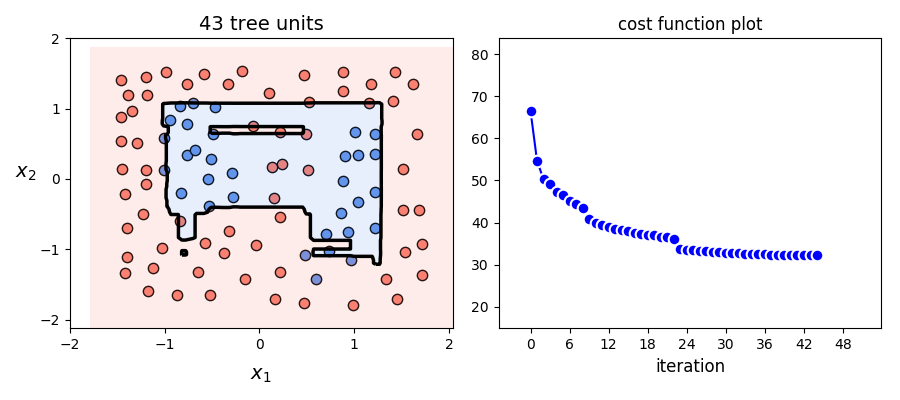
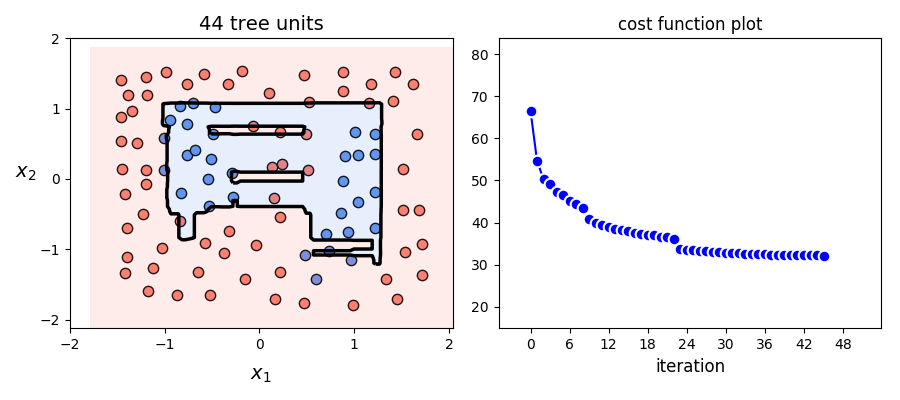
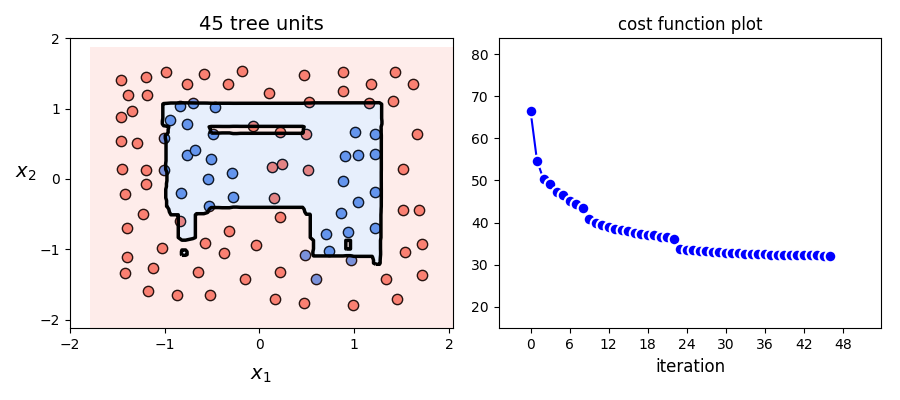
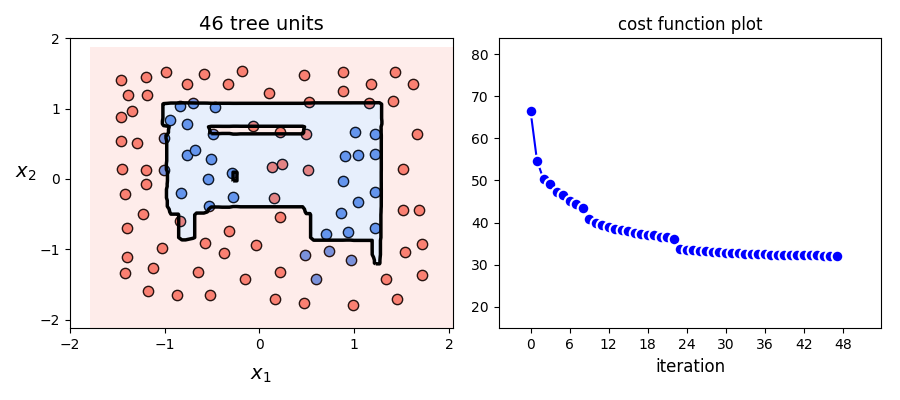
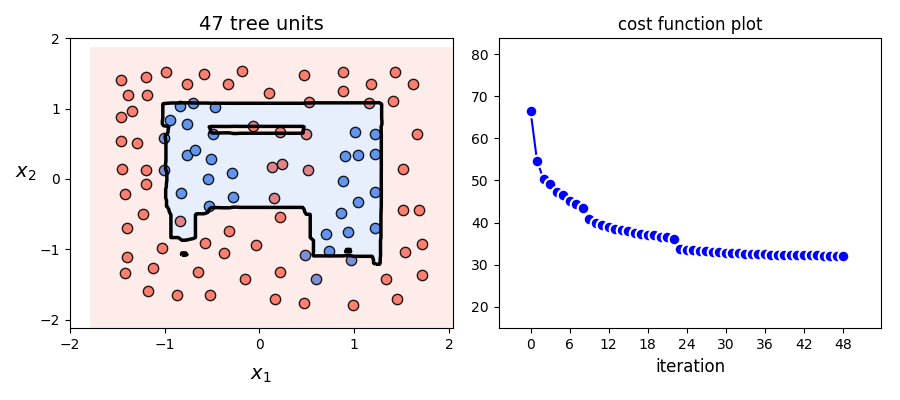
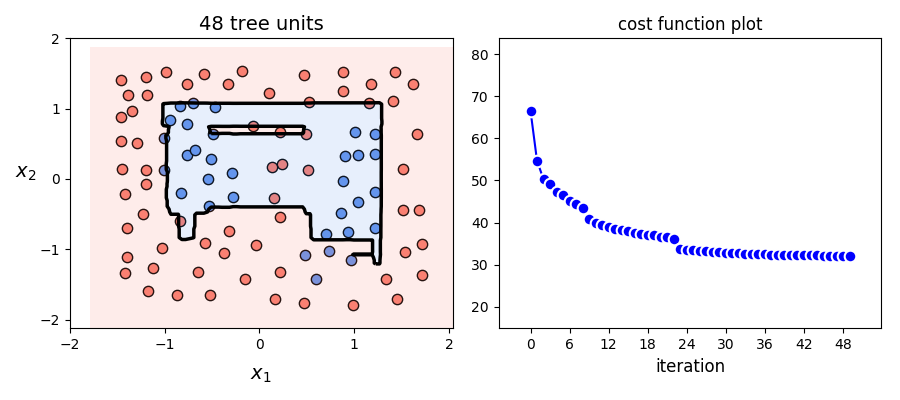

In [34]:
# an animation illustrating gradient boosting fit to a regression dataset
demo = nonlib.classification_basis_single_3d.Visualizer()
csvname = datapath + '2_eggs.csv'
demo.load_data(csvname)
demo.brows_single_fit(basis='tree',num_units = [v for v in range(50)])

 We can use this sort of greedy approach with kernels and neural networks (where instead an entire linear combination of units is fit simultaneously), but there we do not really need such a framework since we have other ways of controlling the nonlinearity (e.g., by adjusting the degree of a polynomial, the architecture of a network, etc.,).

If you reflect for a moment on the qualities of trees discussed above, a procedure like this is essentially a necessary one for stumps.  As we often repeat, one of the main issues with nonlinear supervised learning - regardless of the catalog of functions used - is gaining fine control over the amount and quality of nonlinearity we permit in a model.  With stumps being un-ordered and fixed in shape, adding them greedily one element at a time is an intuitive way of gaining just this sort of fine grained control.  (An alternative would be to simply start adding random stumps together into a working model without considering the quality of each stump added.  The more stumps we add at random the more nonlinear the model wouuld become.  This is the essence of *random forests* - another tree-based algorithm.)

## 2.2  Details of the algorithm

Having reasoned out above that we want to find the best subset of our stumps $f_0,\,f_1,\,...,f_U$ (we once again write the bias as a trivial stump here as $f_0\,\left(\mathbf{x}\right) = 1$) to fit a regression or classification dataset, we can now translate this desire into a formal gradient boosting algorithm.  Using as our prediction the complete linear combination of all generated stumps

\begin{equation}
\text{predict}(\mathbf{x},\omega) = w_0\,f_0\left(\mathbf{x}\right) + w_1\,f_1\left(\mathbf{x}\right) + w_2\,f_2\left(\mathbf{x}\right) + \cdots + w_U\,f_U\left(\mathbf{x}\right)
\end{equation}

our goal here will be to minimize a cost function (e.g., either the Least Squares cost for regression, or the two-class or  multiclass softmax cost for classification) over our entire dataset by sequentially finding the $B$ best stump features one at a time.  Because the algorithm is precisely the same for both regression and classification, we will use a generic cost function in the derivations that follow whose $p^{th}$ summand compares the prediction of $\mathbf{x}_p$ to its corresponding output $y_p$ as $\ell \left(\mathbf{x}_p, y_p \right)$.  Summing over all points then gives a generic cost function 

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{p=1}^{P}\ell \left(\mathbf{x}_p, y_p \right).
\end{equation}

Starting with an initial weight vector $\mathbf{w}^\left(0\right)= \begin{bmatrix} w_0 \\ w_{1} \\ \vdots \\ w_{U} \end{bmatrix}$ that is set to all zeros we then find the $B$ best stumps one-at-a-time, replacing their zero entries in this initial vector with our computed estimates.  As mentioned previously this approach is just a slight adjustment of the general *coordinate descent* optimization method.  

To determine the first / best stump to begin our model we compute - or approximately compute - the minimum of $g$ along each of the input weights independently, keeping all other weights fixed at their initial values.  Formally we minimize $g$ over for each $w_u$, giving estimates

\begin{equation}
\hat{w}_u = \underset{w_u}{\text{argmin}}\,\,\,g\left(w_1^{0},w_2^0,...,w_{u-1}^0,w_{u \phantom{1}}^{\phantom{1}},w_{u+1}^0,...,w_N^0\right).
\end{equation}

We can then choose the best stump based on e.g., temporarily substituting in each of these  into the initial weight vector $\mathbf{w}^{(0)}[u] \longleftarrow w_u^1$, running each through our cost function $g$, and picking the one that provides the lowest value.  

Each of these tentative Least Squares costs can be minimized in closed form as well by examining the first order equation, in general giving the closed form solution

\begin{equation}
w_{u}^1 = \frac{\sum_{p=1}^{P} y_pf_u\left(\mathbf{x}_p\right)}{\sum_{p=1}^{P} f_u\left(\mathbf{x}_p\right)^2}.
\end{equation}